In [1]:
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.manifold import TSNE
import skimage
import scipy
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import grangercausalitytests
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

c:\Users\Jorge\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Training period analysis

1. Load data

In [2]:
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '86L', '87L2', '927R', '927L', '933R']
non_animals = ['87R2', '87L', '87B', '86L2', '583L2', '583B']
full_data = pd.read_pickle('fully_labeled_traces_feats3_071924.pickle')
# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
	'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
	'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)',
	'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping

TW_agg_dict = pd.read_pickle('time-warped_agg_data.pickle')
TW_obs_dict = pd.read_pickle('time-warped_obs_data.pickle')
TW_non_dict = pd.read_pickle('time-warped_non_data.pickle')


In [33]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

In [106]:
full_data['3095_d1_balbc_t1']

PrL (E)   PrL (I)   vLS (E)   vLS (I)   POA (E)   POA (I)  BNST (E)  \
0     -0.445144 -0.917106 -0.796197 -0.779305 -0.613402 -0.484051       NaN   
1     -0.605299 -1.043437 -0.898095 -0.798017 -0.660480 -0.632012       NaN   
2     -0.737057 -1.129971 -0.976553 -0.836116 -0.730437 -0.753815       NaN   
3     -0.840632 -1.177196 -1.031742 -0.887316 -0.812514 -0.849883       NaN   
4     -0.916240 -1.185599 -1.063835 -0.945330 -0.895955 -0.920637       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
21606  0.106515  0.343440  0.024869 -0.493035  0.176014  0.036692       NaN   
21607  0.114650  0.335537  0.026393 -0.431282  0.199015  0.055172       NaN   
21608  0.103429  0.322887  0.012532 -0.362826  0.226411  0.065774       NaN   
21609  0.069641  0.305164 -0.018724 -0.287305  0.258539  0.066779       NaN   
21610  0.010076  0.282038 -0.069388 -0.204359  0.295733  0.056465       NaN   

       BNST (I)    AH (E)    AH (I)  ...  PAG (I)  PMv (E)  PMv (I)  LHb (E)  \
0           NaN -0.191755 -0.905187  ...      NaN      NaN      NaN      NaN   
1           NaN -0.385685 -0.942072  ...      NaN      NaN      NaN      NaN   
2           NaN -0.554598 -0.977626  ...      NaN      NaN      NaN      NaN   
3           NaN -0.695823 -1.009212  ...      NaN      NaN      NaN      NaN   
4           NaN -0.806685 -1.034196  ...      NaN      NaN      NaN      NaN   
...         ...       ...       ...  ...      ...      ...      ...      ...   
21606       NaN  0.057763 -0.345375  ...      NaN      NaN      NaN      NaN   
21607       NaN  0.051981 -0.298395  ...      NaN      NaN      NaN      NaN   
21608       NaN  0.041177 -0.244767  ...      NaN      NaN      NaN      NaN   
21609       NaN  0.025227 -0.184146  ...      NaN      NaN      NaN      NaN   
21610       NaN  0.004008 -0.116183  ...      NaN      NaN      NaN      NaN   

       LHb (I)  PA (E)  PA (I)  NAc (DA)  unsupervised labels  attack labels  
0          NaN     NaN     NaN -0.647004                 10.0              0  
1          NaN     NaN     NaN -0.849862                 10.0              0  
2          NaN     NaN     NaN -1.007445                 10.0              0  
3          NaN     NaN     NaN -1.122185                 10.0              0  
4          NaN     NaN     NaN -1.196516                 10.0              0  
...        ...     ...     ...       ...                  ...            ...  
21606      NaN     NaN     NaN  0.166714                 10.0              0  
21607      NaN     NaN     NaN  0.113588                 10.0              0  
21608      NaN     NaN     NaN  0.049386                 10.0              0  
21609      NaN     NaN     NaN -0.027117                 10.0              0  
21610      NaN     NaN     NaN -0.117142                 10.0              0  

[21611 rows x 25 columns]

2. Descriptive: work out PETHs from time warped data

In [4]:
# format into 3d matrices (window x region x animal

agg_peths = np.zeros((480, len(region_ids), len(TW_agg_dict.keys())))
for k, key in enumerate(TW_agg_dict.keys()):
    peths = np.nanmean(TW_agg_dict[key], axis=0)
    agg_peths[:, :, k] = peths

obs_peths = np.zeros((480, len(region_ids), len(TW_obs_dict.keys())))
for k, key in enumerate(TW_obs_dict.keys()):
    peths = np.nanmean(TW_obs_dict[key], axis=0)
    obs_peths[:, :, k] = peths

non_peths = np.zeros((480, len(region_ids), len(TW_non_dict.keys())))
for k, key in enumerate(TW_non_dict.keys()):
    peths = np.nanmean(TW_non_dict[key], axis=0)
    non_peths[:, :, k] = peths

# early peths vs late peths

ntrials = 25

agg_peths_early = np.zeros((480, len(region_ids), len(TW_agg_dict.keys())))
for k, key in enumerate(TW_agg_dict.keys()):
    peths = np.nanmean(TW_agg_dict[key][:ntrials], axis=0)
    agg_peths_early[:, :, k] = peths

agg_peths_late = np.zeros((480, len(region_ids), len(TW_agg_dict.keys())))
for k, key in enumerate(TW_agg_dict.keys()):
    peths = np.nanmean(TW_agg_dict[key][-ntrials:], axis=0)
    agg_peths_late[:, :, k] = peths

obs_peths_early = np.zeros((480, len(region_ids), len(TW_obs_dict.keys())))
for k, key in enumerate(TW_obs_dict.keys()):
    peths = np.nanmean(TW_obs_dict[key][:ntrials], axis=0)
    obs_peths_early[:, :, k] = peths

obs_peths_late = np.zeros((480, len(region_ids), len(TW_obs_dict.keys())))
for k, key in enumerate(TW_obs_dict.keys()):
    peths = np.nanmean(TW_obs_dict[key][-ntrials:], axis=0)
    obs_peths_late[:, :, k] = peths

C:\Users\Jorge\AppData\Local\Temp\ipykernel_64144\2988714163.py:5: RuntimeWarning: Mean of empty slice
  peths = np.nanmean(TW_agg_dict[key], axis=0)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_64144\2988714163.py:24: RuntimeWarning: Mean of empty slice
  peths = np.nanmean(TW_agg_dict[key][:ntrials], axis=0)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_64144\2988714163.py:29: RuntimeWarning: Mean of empty slice
  peths = np.nanmean(TW_agg_dict[key][-ntrials:], axis=0)


In [5]:
# format into 3d matrices (window x region x trial)

agg_peths_notGrouped = []
for k, key in enumerate(TW_agg_dict.keys()):
    peths = TW_agg_dict[key]
    agg_peths_notGrouped.append(peths)
agg_peths_notGrouped = np.transpose(np.concatenate(agg_peths_notGrouped, axis=0), [1, 2, 0])

obs_peths_notGrouped = []
for k, key in enumerate(TW_obs_dict.keys()):
    peths = TW_obs_dict[key]
    obs_peths_notGrouped.append(peths)
obs_peths_notGrouped = np.transpose(np.concatenate(obs_peths_notGrouped, axis=0), [1, 2, 0])

non_peths_notGrouped = []
for k, key in enumerate(TW_non_dict.keys()):
    peths = TW_non_dict[key]
    non_peths_notGrouped.append(peths)
non_peths_notGrouped = np.transpose(np.concatenate(non_peths_notGrouped, axis=0), [1, 2, 0])

ntrials=25

agg_peths_early_notGrouped = []
for k, key in enumerate(TW_agg_dict.keys()):
    peths = TW_agg_dict[key][:ntrials]
    agg_peths_early_notGrouped.append(peths)
agg_peths_early_notGrouped = np.transpose(np.concatenate(agg_peths_early_notGrouped, axis=0), [1, 2, 0])

agg_peths_late_notGrouped = []
for k, key in enumerate(TW_agg_dict.keys()):
    peths = TW_agg_dict[key][-ntrials:]
    agg_peths_late_notGrouped.append(peths)
agg_peths_late_notGrouped = np.transpose(np.concatenate(agg_peths_late_notGrouped, axis=0), [1, 2, 0])

obs_peths_early_notGrouped = []
for k, key in enumerate(TW_obs_dict.keys()):
    peths = TW_obs_dict[key][:ntrials]
    obs_peths_early_notGrouped.append(peths)
obs_peths_early_notGrouped = np.transpose(np.concatenate(obs_peths_early_notGrouped, axis=0), [1, 2, 0])

obs_peths_late_notGrouped = []
for k, key in enumerate(TW_obs_dict.keys()):
    peths = TW_obs_dict[key][-ntrials:]
    obs_peths_late_notGrouped.append(peths)
obs_peths_late_notGrouped = np.transpose(np.concatenate(obs_peths_late_notGrouped, axis=0), [1, 2, 0])


3. Determine significance in activity (relative to NON)

In [425]:
# stats config

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

def run_atk_stats_noANOVA(data2plot):

    agg_roi_activity = data2plot[0][np.isnan(data2plot[0])==False]
    obs_roi_activity = data2plot[1][np.isnan(data2plot[1])==False]
    non_roi_activity = data2plot[2][np.isnan(data2plot[2])==False]

    # Add the data to the DataFrame
    df = pd.DataFrame({
        'Activity': np.concatenate([agg_roi_activity, obs_roi_activity, non_roi_activity]),
        'Group': np.concatenate([['agg'] * len(agg_roi_activity), ['obs'] * len(obs_roi_activity), ['non'] * len(non_roi_activity)]),
    })

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05 and p_non > 0.05:
        # Perform t-tests
        t1, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
        test_type1='t' 
        
    else:
        # Perform Wilcoxon rank-sum tests
        t1, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
        test_type1='U'

    if p_obs > 0.05 and p_non > 0.05:
        # Perform t-tests
        t2, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
        test_type2='t'
    
    else:
        # Perform Wilcoxon rank-sum tests
        t2, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
        test_type2='U'

    return p_agg_non, p_obs_non, t1, t2, test_type1, test_type2

# stats config

def run_atk_stats_vs_0(data2plot):
    agg_roi_activity = data2plot[0][np.isnan(data2plot[0]) == False]

    # Test for normality on agg_roi_activity
    _, p_agg = stats.shapiro(agg_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05:
        # Perform one-sample t-test
        _, p_agg_zero = stats.ttest_1samp(agg_roi_activity, 0)
    else:
        # Perform Wilcoxon signed-rank test
        _, p_agg_zero = stats.wilcoxon(agg_roi_activity - 0)

    return p_agg_zero

In [431]:
# pre-attack statistics
from statsmodels.stats.multitest import multipletests

# compute p-values for all regions
start = 200 # -1s
stop = start+40 # 0s
agg_diff = agg_peths[start:stop] - np.nanmedian(agg_peths[0:120])
obs_diff = obs_peths[start:stop] - np.nanmedian(obs_peths[0:120])
non_diff = non_peths[start:stop] - np.nanmedian(non_peths[0:120])
idxs2loop = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
pval_names = [region_ids[idx] for idx in idxs2loop]
p_values = []
t_values = []
test_types = []
for r, roi in enumerate(idxs2loop):
    pval1, pval2, t1, t2, test_type1, test_type2 = run_atk_stats_noANOVA([np.nanmean(agg_diff[:, roi], axis=0), np.nanmean(obs_diff[:, roi], axis=0), np.nanmean(non_diff[:, roi], axis=0)])
    p_values.extend([pval1, pval2])
    t_values.extend([t1, t2])
    test_types.extend([test_type1, test_type2])

# correct for multiple comparisons
pvals_uncorrected = np.array(p_values)
pvals_uncorrected_AGG = pvals_uncorrected[0::2]
pvals_uncorrected_OBS = pvals_uncorrected[1::2]
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
pvals_corrected_AGG = pvals_corrected[0::2]
pvals_corrected_OBS = pvals_corrected[1::2]
tvals_AGG = t_values[0::2]
tvals_OBS = t_values[1::2]
test_types_AGG = test_types[0::2]
test_types_OBS = test_types[1::2]

### AGG
for i, p in enumerate(pval_names):
    print('%s AGG vs NON; %s = %f, p = %f' % (p, test_types_AGG[i], tvals_AGG[i], pvals_corrected_AGG[i]))

### OBS
for i, p in enumerate(pval_names):
    print('%s OBS vs NON; %s = %f, p = %f' % (p, test_types_OBS[i], tvals_OBS[i], pvals_corrected_OBS[i]))


VMH (E) AGG vs NON; t = 3.546959, p = 0.022816
PMv (E) AGG vs NON; t = 3.766657, p = 0.022816
AH (E) AGG vs NON; t = 0.398173, p = 0.644692
POA (E) AGG vs NON; t = 1.801888, p = 0.197460
MeA (E) AGG vs NON; t = 4.407648, p = 0.008727
PA (E) AGG vs NON; U = 37.000000, p = 0.068279
BNST (E) AGG vs NON; t = 2.226208, p = 0.121368
PAG (E) AGG vs NON; t = -0.005127, p = 0.801131
vLS (E) AGG vs NON; t = 0.254896, p = 0.690774
PrL (E) AGG vs NON; t = 2.081704, p = 0.142314
LHb (E) AGG vs NON; t = -1.672664, p = 0.222844
VMH (I) AGG vs NON; t = 3.183026, p = 0.031296
PMv (I) AGG vs NON; t = 2.023977, p = 0.157136
AH (I) AGG vs NON; t = -0.719047, p = 0.493590
POA (I) AGG vs NON; t = 1.189749, p = 0.339809
MeA (I) AGG vs NON; t = 3.448993, p = 0.022816
PA (I) AGG vs NON; t = 3.642903, p = 0.022816
BNST (I) AGG vs NON; t = 1.371174, p = 0.277268
PAG (I) AGG vs NON; t = 1.653379, p = 0.222844
vLS (I) AGG vs NON; t = 1.043401, p = 0.376896
PrL (I) AGG vs NON; t = 4.814569, p = 0.008727
LHb (I) AGG

In [430]:
# post-attack statistics
from statsmodels.stats.multitest import multipletests

# compute p-values for all regions
start = 240 # 0s
stop = start+40 # 1
agg_diff = agg_peths[start:stop] - np.nanmedian(agg_peths[0:120])
obs_diff = obs_peths[start:stop] - np.nanmedian(obs_peths[0:120])
non_diff = non_peths[start:stop] - np.nanmedian(non_peths[0:120])
idxs2loop = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
pval_names = [region_ids[idx] for idx in idxs2loop]
p_values = []
t_values = []
test_types = []
for r, roi in enumerate(idxs2loop):
    pval1, pval2, t1, t2, test_type1, test_type2 = run_atk_stats_noANOVA([np.nanmean(agg_diff[:, roi], axis=0), np.nanmean(obs_diff[:, roi], axis=0), np.nanmean(non_diff[:, roi], axis=0)])
    p_values.extend([pval1, pval2])
    t_values.extend([t1, t2])
    test_types.extend([test_type1, test_type2])

# correct for multiple comparisons
pvals_uncorrected = np.array(p_values)
pvals_uncorrected_AGG = pvals_uncorrected[0::2]
pvals_uncorrected_OBS = pvals_uncorrected[1::2]
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
pvals_corrected_AGG = pvals_corrected[0::2]
pvals_corrected_OBS = pvals_corrected[1::2]
tvals_AGG = t_values[0::2]
tvals_OBS = t_values[1::2]
test_types_AGG = test_types[0::2]
test_types_OBS = test_types[1::2]

### AGG
for i, p in enumerate(pval_names):
    print('%s AGG vs NON; %s = %f, p = %f' % (p, test_types_AGG[i], tvals_AGG[i], pvals_corrected_AGG[i]))

### OBS
for i, p in enumerate(pval_names):
    print('%s OBS vs NON; %s = %f, p = %f' % (p, test_types_OBS[i], tvals_OBS[i], pvals_corrected_OBS[i]))


VMH (E) AGG vs NON; t = 5.653069, p = 0.000841
PMv (E) AGG vs NON; t = 4.704095, p = 0.001534
AH (E) AGG vs NON; t = 1.823951, p = 0.049521
POA (E) AGG vs NON; t = 4.438049, p = 0.001709
MeA (E) AGG vs NON; t = 5.169480, p = 0.000857
PA (E) AGG vs NON; U = 38.000000, p = 0.013986
BNST (E) AGG vs NON; t = 3.050580, p = 0.010634
PAG (E) AGG vs NON; t = 3.492130, p = 0.006384
vLS (E) AGG vs NON; t = 2.278653, p = 0.026351
PrL (E) AGG vs NON; t = 2.524605, p = 0.019648
LHb (E) AGG vs NON; t = -0.663081, p = 0.230179
VMH (I) AGG vs NON; t = 4.949127, p = 0.001010
PMv (I) AGG vs NON; t = 3.154741, p = 0.010243
AH (I) AGG vs NON; t = 4.623384, p = 0.001295
POA (I) AGG vs NON; t = 2.503360, p = 0.019648
MeA (I) AGG vs NON; t = 5.346276, p = 0.000841
PA (I) AGG vs NON; t = 4.090730, p = 0.003127
BNST (I) AGG vs NON; t = 2.695010, p = 0.018514
PAG (I) AGG vs NON; t = 2.628597, p = 0.019594
vLS (I) AGG vs NON; t = 2.573311, p = 0.019594
PrL (I) AGG vs NON; t = 5.356345, p = 0.000841
LHb (I) AGG v

4. Significance in EI bias (supp)

In [417]:
E_idxs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
I_idxs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
mean_func1 = np.nanmean
mean_func2 = np.nanmean
periods = [230, 250]

agg_EIs = np.zeros((11, len(TW_agg_dict.keys())))
for k, key in enumerate(list(TW_agg_dict.keys())):
    E_peth =  (np.transpose(TW_agg_dict[key][:, :, E_idxs], [0, 2, 1]) - np.nanmedian(TW_agg_dict[key][:, :80, E_idxs], axis=1).reshape(TW_agg_dict[key].shape[0], 11, 1))
    I_peth =  (np.transpose(TW_agg_dict[key][:, :, I_idxs], [0, 2, 1]) - np.nanmedian(TW_agg_dict[key][:, :80, I_idxs], axis=1).reshape(TW_agg_dict[key].shape[0], 11, 1))
    E_peth = np.transpose(E_peth, [0, 2, 1])
    I_peth = np.transpose(I_peth, [0, 2, 1])
    mean_E = mean_func1(mean_func2(E_peth[:, periods[0]:periods[1], :], axis=1), axis=0)
    mean_I = mean_func1(mean_func2(I_peth[:, periods[0]:periods[1], :], axis=1), axis=0)
    EI = (mean_E - mean_I) / (mean_E + mean_I + 2)
    # EI = mean_E - mean_I
    agg_EIs[:, k] = EI

obs_EIs = np.zeros((11, len(TW_obs_dict.keys())))
for k, key in enumerate(list(TW_obs_dict.keys())):
    E_peth =  (np.transpose(TW_obs_dict[key][:, :, E_idxs], [0, 2, 1]) - np.nanmedian(TW_obs_dict[key][:, :80, E_idxs], axis=1).reshape(TW_obs_dict[key].shape[0], 11, 1))
    I_peth =  (np.transpose(TW_obs_dict[key][:, :, I_idxs], [0, 2, 1]) - np.nanmedian(TW_obs_dict[key][:, :80, I_idxs], axis=1).reshape(TW_obs_dict[key].shape[0], 11, 1))
    E_peth = np.transpose(E_peth, [0, 2, 1])
    I_peth = np.transpose(I_peth, [0, 2, 1])
    mean_E = mean_func1(mean_func2(E_peth[:, periods[0]:periods[1], :], axis=1), axis=0)
    mean_I = mean_func1(mean_func2(I_peth[:, periods[0]:periods[1], :], axis=1), axis=0)
    EI = (mean_E - mean_I) / (mean_E + mean_I + 2)
    # EI = mean_E - mean_I
    obs_EIs[:, k] = EI

non_EIs = np.zeros((11, len(TW_non_dict.keys())))
for k, key in enumerate(list(TW_non_dict.keys())):
    E_peth = (np.transpose(TW_non_dict[key][:, :, E_idxs], [0, 2, 1]) - np.nanmedian(TW_non_dict[key][:, :80, E_idxs], axis=1).reshape(TW_non_dict[key].shape[0], 11, 1))
    I_peth = (np.transpose(TW_non_dict[key][:, :, I_idxs], [0, 2, 1]) - np.nanmedian(TW_non_dict[key][:, :80, I_idxs], axis=1).reshape(TW_non_dict[key].shape[0], 11, 1))
    E_peth = np.transpose(E_peth, [0, 2, 1])
    I_peth = np.transpose(I_peth, [0, 2, 1])
    mean_E = mean_func1(mean_func2(E_peth[:, periods[0]:periods[1], :], axis=1), axis=0)
    mean_I = mean_func1(mean_func2(I_peth[:, periods[0]:periods[1], :], axis=1), axis=0)
    EI = (mean_E - mean_I) / (mean_E + mean_I + 2)
    # EI = mean_E - mean_I
    non_EIs[:, k] = EI

In [429]:
idxs2loop = (np.array([12, 16, 8, 4, 10, 20, 6, 14, 0, 2, 18])/2).astype(int)
labels2loop = ['VMHvl', 'PMv', 'AH', 'POA', 'MeA', 'PA', 'BNST', 'lPAG', 'vLS', 'PrL', 'LHb']
agg_prep = agg_EIs.copy().T
obs_prep = obs_EIs.copy().T
non_prep = non_EIs.copy().T

p_values = []
t_values = []
test_types = []
for r, (roi, roi_amp) in enumerate(zip(idxs2loop, amped_idxs)):
    pval1, pval2, t1, t2, test_type1, test_type2 = run_atk_stats_noANOVA([agg_prep[:, roi], obs_prep[:, roi], non_prep[:, roi]])
    p_values.extend([pval1, pval2])
    t_values.extend([t1, t2])
    test_types.extend([test_type1, test_type2])

# correct for multiple comparisons
pvals_uncorrected = np.array(p_values)
pvals_uncorrected_AGG = pvals_uncorrected[0::2]
pvals_uncorrected_OBS = pvals_uncorrected[1::2]
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
pvals_corrected_AGG = pvals_corrected[0::2]
pvals_corrected_OBS = pvals_corrected[1::2]
tvals_AGG = t_values[0::2]
tvals_OBS = t_values[1::2]
test_types_AGG = test_types[0::2]
test_types_OBS = test_types[1::2]

### AGG

rows = []

for i, p in enumerate(pval_names[:11]):
    print('%s AGG vs NON; %s = %f, p = %f' % (p, test_types_AGG[i], tvals_AGG[i], pvals_corrected_AGG[i]))
    rows.append('p = %f' % pvals_corrected_AGG[i])

### OBS
for i, p in enumerate(pval_names[:11]):
    print('%s OBS vs NON; %s = %f, p = %f' % (p, test_types_OBS[i], tvals_OBS[i], pvals_corrected_OBS[i]))
    rows.append('p = %f' % pvals_corrected_OBS[i])

df = pd.DataFrame(rows)
df.to_excel('EI_stats.xlsx')

VMH (E) AGG vs NON; t = 3.592358, p = 0.029515
PMv (E) AGG vs NON; t = 3.250701, p = 0.034765
AH (E) AGG vs NON; U = 36.000000, p = 0.445910
POA (E) AGG vs NON; t = 1.023375, p = 0.445910
MeA (E) AGG vs NON; t = -0.246774, p = 0.766361
PA (E) AGG vs NON; t = -0.493170, p = 0.668678
BNST (E) AGG vs NON; t = 0.739659, p = 0.532945
PAG (E) AGG vs NON; t = 1.626096, p = 0.297471
vLS (E) AGG vs NON; t = -0.925453, p = 0.445910
PrL (E) AGG vs NON; t = 0.437856, p = 0.668678
LHb (E) AGG vs NON; t = -5.718022, p = 0.002422
VMH (E) OBS vs NON; t = 2.363476, p = 0.112747
PMv (E) OBS vs NON; t = 3.469271, p = 0.031480
AH (E) OBS vs NON; U = 34.000000, p = 0.188811
POA (E) OBS vs NON; t = 2.629289, p = 0.084373
MeA (E) OBS vs NON; U = 13.000000, p = 0.445910
PA (E) OBS vs NON; t = -0.074439, p = 0.810190
BNST (E) OBS vs NON; t = 0.961871, p = 0.445910
PAG (E) OBS vs NON; t = 1.115688, p = 0.445910
vLS (E) OBS vs NON; U = 20.000000, p = 0.810190
PrL (E) OBS vs NON; t = -0.974411, p = 0.445910
LHb (

C:\Users\Jorge\AppData\Local\Temp\ipykernel_64144\3224047388.py:42: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df.to_excel('EI_stats.xlsx')


5. Activity PETHs:

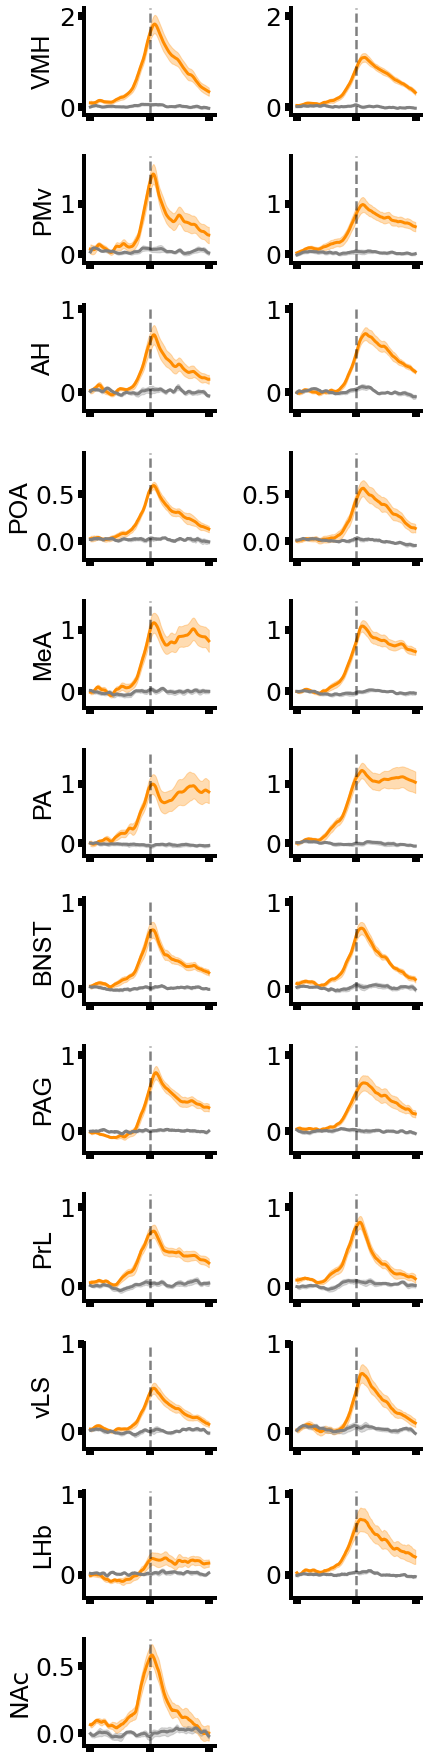

In [282]:
# plot individually averaged PETHs

from matplotlib.ticker import MaxNLocator
periods = [80, 400]
# periods = [0, 320]
n = periods[1] - periods[0]

fig, ax = plt.subplots(12, 2, figsize=(6.5, 25))
sorting = [12, 16, 8, 4, 10, 20, 6, 14, 0, 2, 18, 22]
agg_color = 'darkorange'
obs_color = 'magenta'
non_color='gray'

for i, r in enumerate(sorting):
    try:

        # plot exc.
        agg_E = agg_peths[:, r, :] - np.nanmedian(agg_peths[:80, r, :], axis=0)
        non_E = non_peths[:, r, :] - np.nanmedian(non_peths[:80, r, :], axis=0)
        ax[i, 0].plot(np.nanmean(agg_E, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color, 
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(agg_E, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_E, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_peths.shape[2]),
        np.nanmean(agg_E, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_E, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_peths.shape[2]), alpha=0.3, color=agg_color)
        ax[i, 0].plot(np.nanmean(non_E, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(non_E, axis=1)[periods[0]:periods[1]] - np.nanstd(non_E, axis=1)[periods[0]:periods[1]]/np.sqrt(non_peths.shape[2]),
        np.nanmean(non_E, axis=1)[periods[0]:periods[1]] + np.nanstd(non_E, axis=1)[periods[0]:periods[1]]/np.sqrt(non_peths.shape[2]), alpha=0.3, color=non_color)
        ax[i, 0].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 0].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot inh.
        agg_I = agg_peths[:, r+1, :] - np.nanmedian(agg_peths[:80, r+1, :], axis=0)
        non_I = non_peths[:, r+1, :] - np.nanmedian(non_peths[:80, r+1, :], axis=0)
        ax[i, 1].plot(np.nanmean(agg_I, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(agg_I, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_I, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I.shape[1]),
        np.nanmean(agg_I, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_I, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 1].plot(np.nanmean(non_I, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(non_I, axis=1)[periods[0]:periods[1]] - np.nanstd(non_I, axis=1)[periods[0]:periods[1]]/np.sqrt(non_I.shape[1]),
        np.nanmean(non_I, axis=1)[periods[0]:periods[1]] + np.nanstd(non_I, axis=1)[periods[0]:periods[1]]/np.sqrt(non_I.shape[1]), alpha=0.3, color=non_color)
        ax[i, 1].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 1].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # fix y scaling
        max1 = np.nanmean(agg_E, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(agg_I, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(agg_E, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(agg_I, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 0].set_ylim(bottom=ylim_bottom-0.2, top=ylim_top+0.35)
        ax[i, 1].set_ylim(bottom=ylim_bottom-0.2, top=ylim_top+0.35)
        ax[i, 0].set_ylabel(region_ids[r].replace(' (E)', '').replace(' (I)', '').replace(' (DA)', ''), fontfamily='Arial')
        sns.despine()
    except IndexError:
        continue
fig.delaxes(ax[11, 1])
# fig.delaxes(ax[11, 2])
ax[11, 0].set_ylabel('NAc');
fig.subplots_adjust(wspace=0.7, hspace=0.25)
# plt.savefig('./figures/obs_PETHs_TW_woEI.svg', dpi=300)
plt.tight_layout()

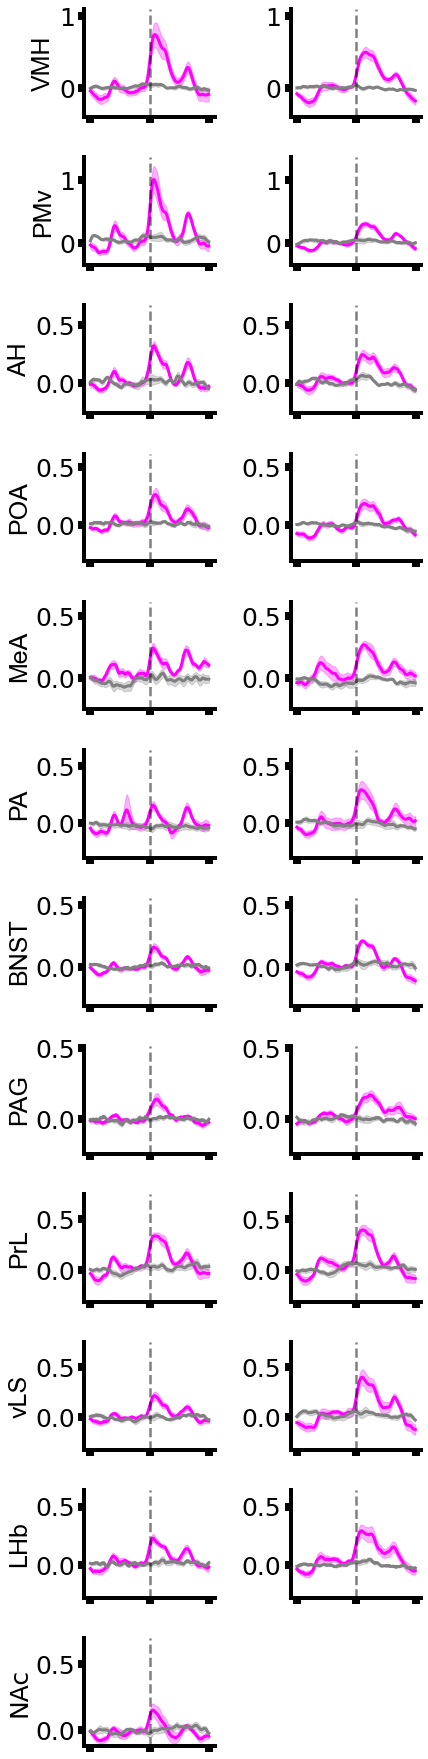

In [352]:
# plot individually averaged PETHs

from matplotlib.ticker import MaxNLocator
periods = [80, 400]
# periods = [0, 320]
n = periods[1] - periods[0]

fig, ax = plt.subplots(12, 2, figsize=(6.5, 25))
sorting = [12, 16, 8, 4, 10, 20, 6, 14, 0, 2, 18, 22]
agg_color = 'darkorange'
obs_color = 'magenta'
non_color='gray'

for i, r in enumerate(sorting):
    try:

        # plot exc.
        obs_E = obs_peths[:, r, :] - np.nanmedian(obs_peths[:80, r, :], axis=0)
        non_E = non_peths[:, r, :] - np.nanmedian(non_peths[:80, r, :], axis=0)
        ax[i, 0].plot(np.nanmean(obs_E, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(obs_E, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_E, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_peths.shape[2]),
        np.nanmean(obs_E, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_E, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_peths.shape[2]), alpha=0.3, color=obs_color)
        ax[i, 0].plot(np.nanmean(non_E, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(non_E, axis=1)[periods[0]:periods[1]] - np.nanstd(non_E, axis=1)[periods[0]:periods[1]]/np.sqrt(non_peths.shape[2]),
        np.nanmean(non_E, axis=1)[periods[0]:periods[1]] + np.nanstd(non_E, axis=1)[periods[0]:periods[1]]/np.sqrt(non_peths.shape[2]), alpha=0.3, color=non_color)
        ax[i, 0].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 0].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot inh.
        obs_I = obs_peths[:, r+1, :] - np.nanmedian(obs_peths[:80, r+1, :], axis=0)
        non_I = non_peths[:, r+1, :] - np.nanmedian(non_peths[:80, r+1, :], axis=0)
        ax[i, 1].plot(np.nanmean(obs_I, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(obs_I, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_I, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I.shape[1]),
        np.nanmean(obs_I, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_I, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 1].plot(np.nanmean(non_I, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(non_I, axis=1)[periods[0]:periods[1]] - np.nanstd(non_I, axis=1)[periods[0]:periods[1]]/np.sqrt(non_I.shape[1]),
        np.nanmean(non_I, axis=1)[periods[0]:periods[1]] + np.nanstd(non_I, axis=1)[periods[0]:periods[1]]/np.sqrt(non_I.shape[1]), alpha=0.3, color=non_color)
        ax[i, 1].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 1].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # fix y scaling
        max1 = np.nanmean(obs_E, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(obs_I, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(obs_E, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(obs_I, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 0].set_ylim(bottom=ylim_bottom-0.2, top=ylim_top+0.35)
        ax[i, 1].set_ylim(bottom=ylim_bottom-0.2, top=ylim_top+0.35)
        ax[i, 0].set_ylabel(region_ids[r].replace(' (E)', '').replace(' (I)', '').replace(' (DA)', ''), fontfamily='Arial')
        sns.despine()
    except IndexError:
        continue
fig.delaxes(ax[11, 1])
# fig.delaxes(ax[11, 2])
ax[11, 0].set_ylabel('NAc');
ax[11, 0].set_ylim(top=0.7)
fig.subplots_adjust(wspace=0.7, hspace=0.25)
plt.savefig('./figures/obs_PETHs.svg', dpi=300)
plt.tight_layout()

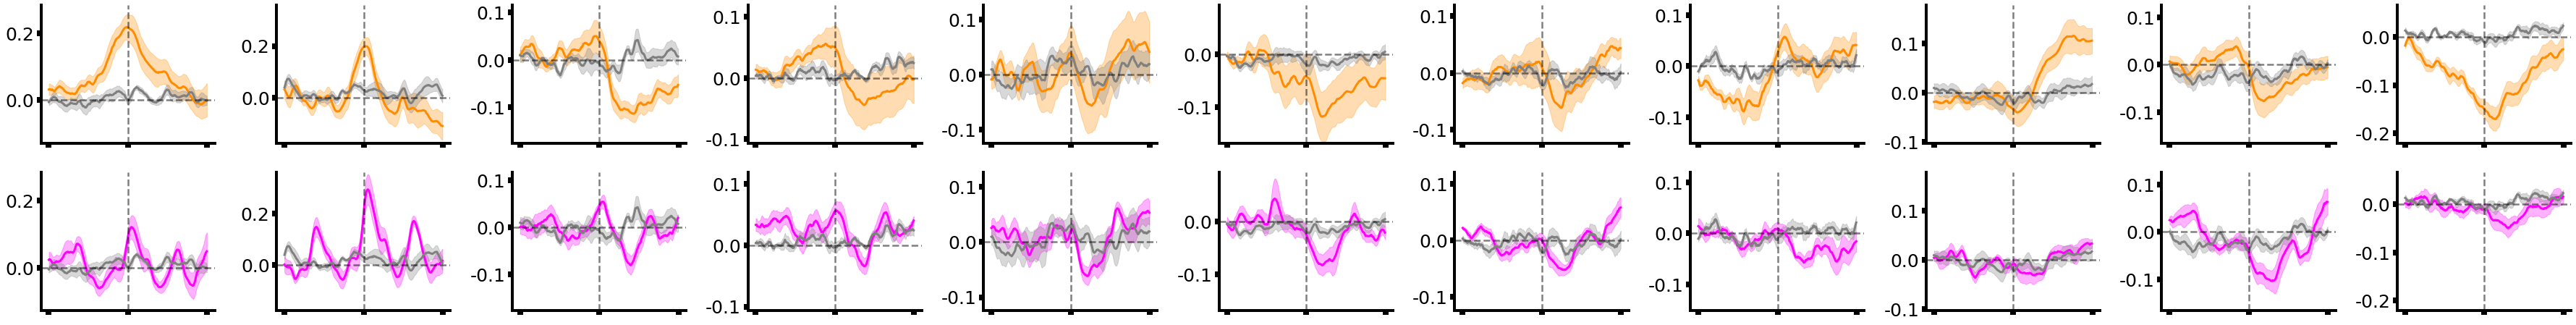

In [344]:
# plot individually averaged PETHs

from matplotlib.ticker import MaxNLocator, FuncFormatter

# Define a formatter function to round y-ticks to a single decimal point
def format_func(value, tick_number):
    return f'{value:.1f}'

periods = [80, 400]
# periods = [0, 320]
n = periods[1] - periods[0]

fig, ax = plt.subplots(2, 11, figsize=(50, 6.8))
sorting = [12, 16, 8, 4, 10, 20, 6, 14, 0, 2, 18]
agg_color = 'darkorange'
obs_color = 'magenta'
non_color='gray'

for i, r in enumerate(sorting):
    try:

        # plot exc.
        agg_E = agg_peths[:, r, :] - np.nanmedian(agg_peths[:80, r, :], axis=0)
        obs_E = obs_peths[:, r, :] - np.nanmedian(obs_peths[:80, r, :], axis=0)
        non_E = non_peths[:, r, :] - np.nanmedian(non_peths[:80, r, :], axis=0)
        agg_I = agg_peths[:, r+1, :] - np.nanmedian(agg_peths[:80, r+1, :], axis=0)
        obs_I = obs_peths[:, r+1, :] - np.nanmedian(obs_peths[:80, r+1, :], axis=0)
        non_I = non_peths[:, r+1, :] - np.nanmedian(non_peths[:80, r+1, :], axis=0)
       
        # plot E-I difference
        agg_EI = (agg_E - agg_I) / (agg_E + agg_I + 2)
        obs_EI = (obs_E - obs_I) / (obs_E + obs_I + 2)
        non_EI = (non_E - non_I) / (non_E + non_I + 2)
        ax[0, i].plot(np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[0, i].fill_between(range(n), np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI.shape[1]),
        np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI.shape[1]), alpha=0.3, color=agg_color)
        ax[0, i].plot(np.nanmean(non_EI, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[0, i].fill_between(range(n), np.nanmean(non_EI, axis=1)[periods[0]:periods[1]] - np.nanstd(non_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(non_EI.shape[1]),
        np.nanmean(non_EI, axis=1)[periods[0]:periods[1]] + np.nanstd(non_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(non_EI.shape[1]), alpha=0.3, color=non_color)
        ax[0, i].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[0, i].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])
        ax[0, i].axhline(0, linestyle='--', color='black', alpha=0.5)


        ax[1, i].plot(np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[1, i].fill_between(range(n), np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI.shape[1]),
        np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI.shape[1]), alpha=0.3, color=obs_color)
        ax[1, i].plot(np.nanmean(non_EI, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[1, i].fill_between(range(n), np.nanmean(non_EI, axis=1)[periods[0]:periods[1]] - np.nanstd(non_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(non_EI.shape[1]),
        np.nanmean(non_EI, axis=1)[periods[0]:periods[1]] + np.nanstd(non_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(non_EI.shape[1]), alpha=0.3, color=non_color)
        ax[1, i].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[1, i].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])
        ax[1, i].axhline(0, linestyle='--', color='black', alpha=0.5)

        # fix y scaling
        # max1 = np.nanmean(agg_E, axis=1)[periods[0]:periods[1]].max()
        max1 = np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]].max()
        # max2 = np.nanmean(agg_I, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]].max()
        # min1 = np.nanmean(agg_E, axis=1)[periods[0]:periods[1]].min()
        min1 = np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]].min()
        # min2 = np.nanmean(agg_I, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[0, i].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        ax[1, i].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        # ax[0, i].set_ylabel(region_ids[r].replace(' (E)', '').replace(' (I)', '').replace(' (DA)', ''), fontfamily='Arial')
        ax[0, i].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[1, i].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[0, i].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[1, i].yaxis.set_major_formatter(FuncFormatter(format_func))
        sns.despine()
    except IndexError:
        continue

fig.subplots_adjust(wspace=0.7, hspace=0.25)
plt.savefig('./figures/EI_peths.svg', dpi=300)
plt.tight_layout()

6. E-I PETHs for early versus late attacks (supp):

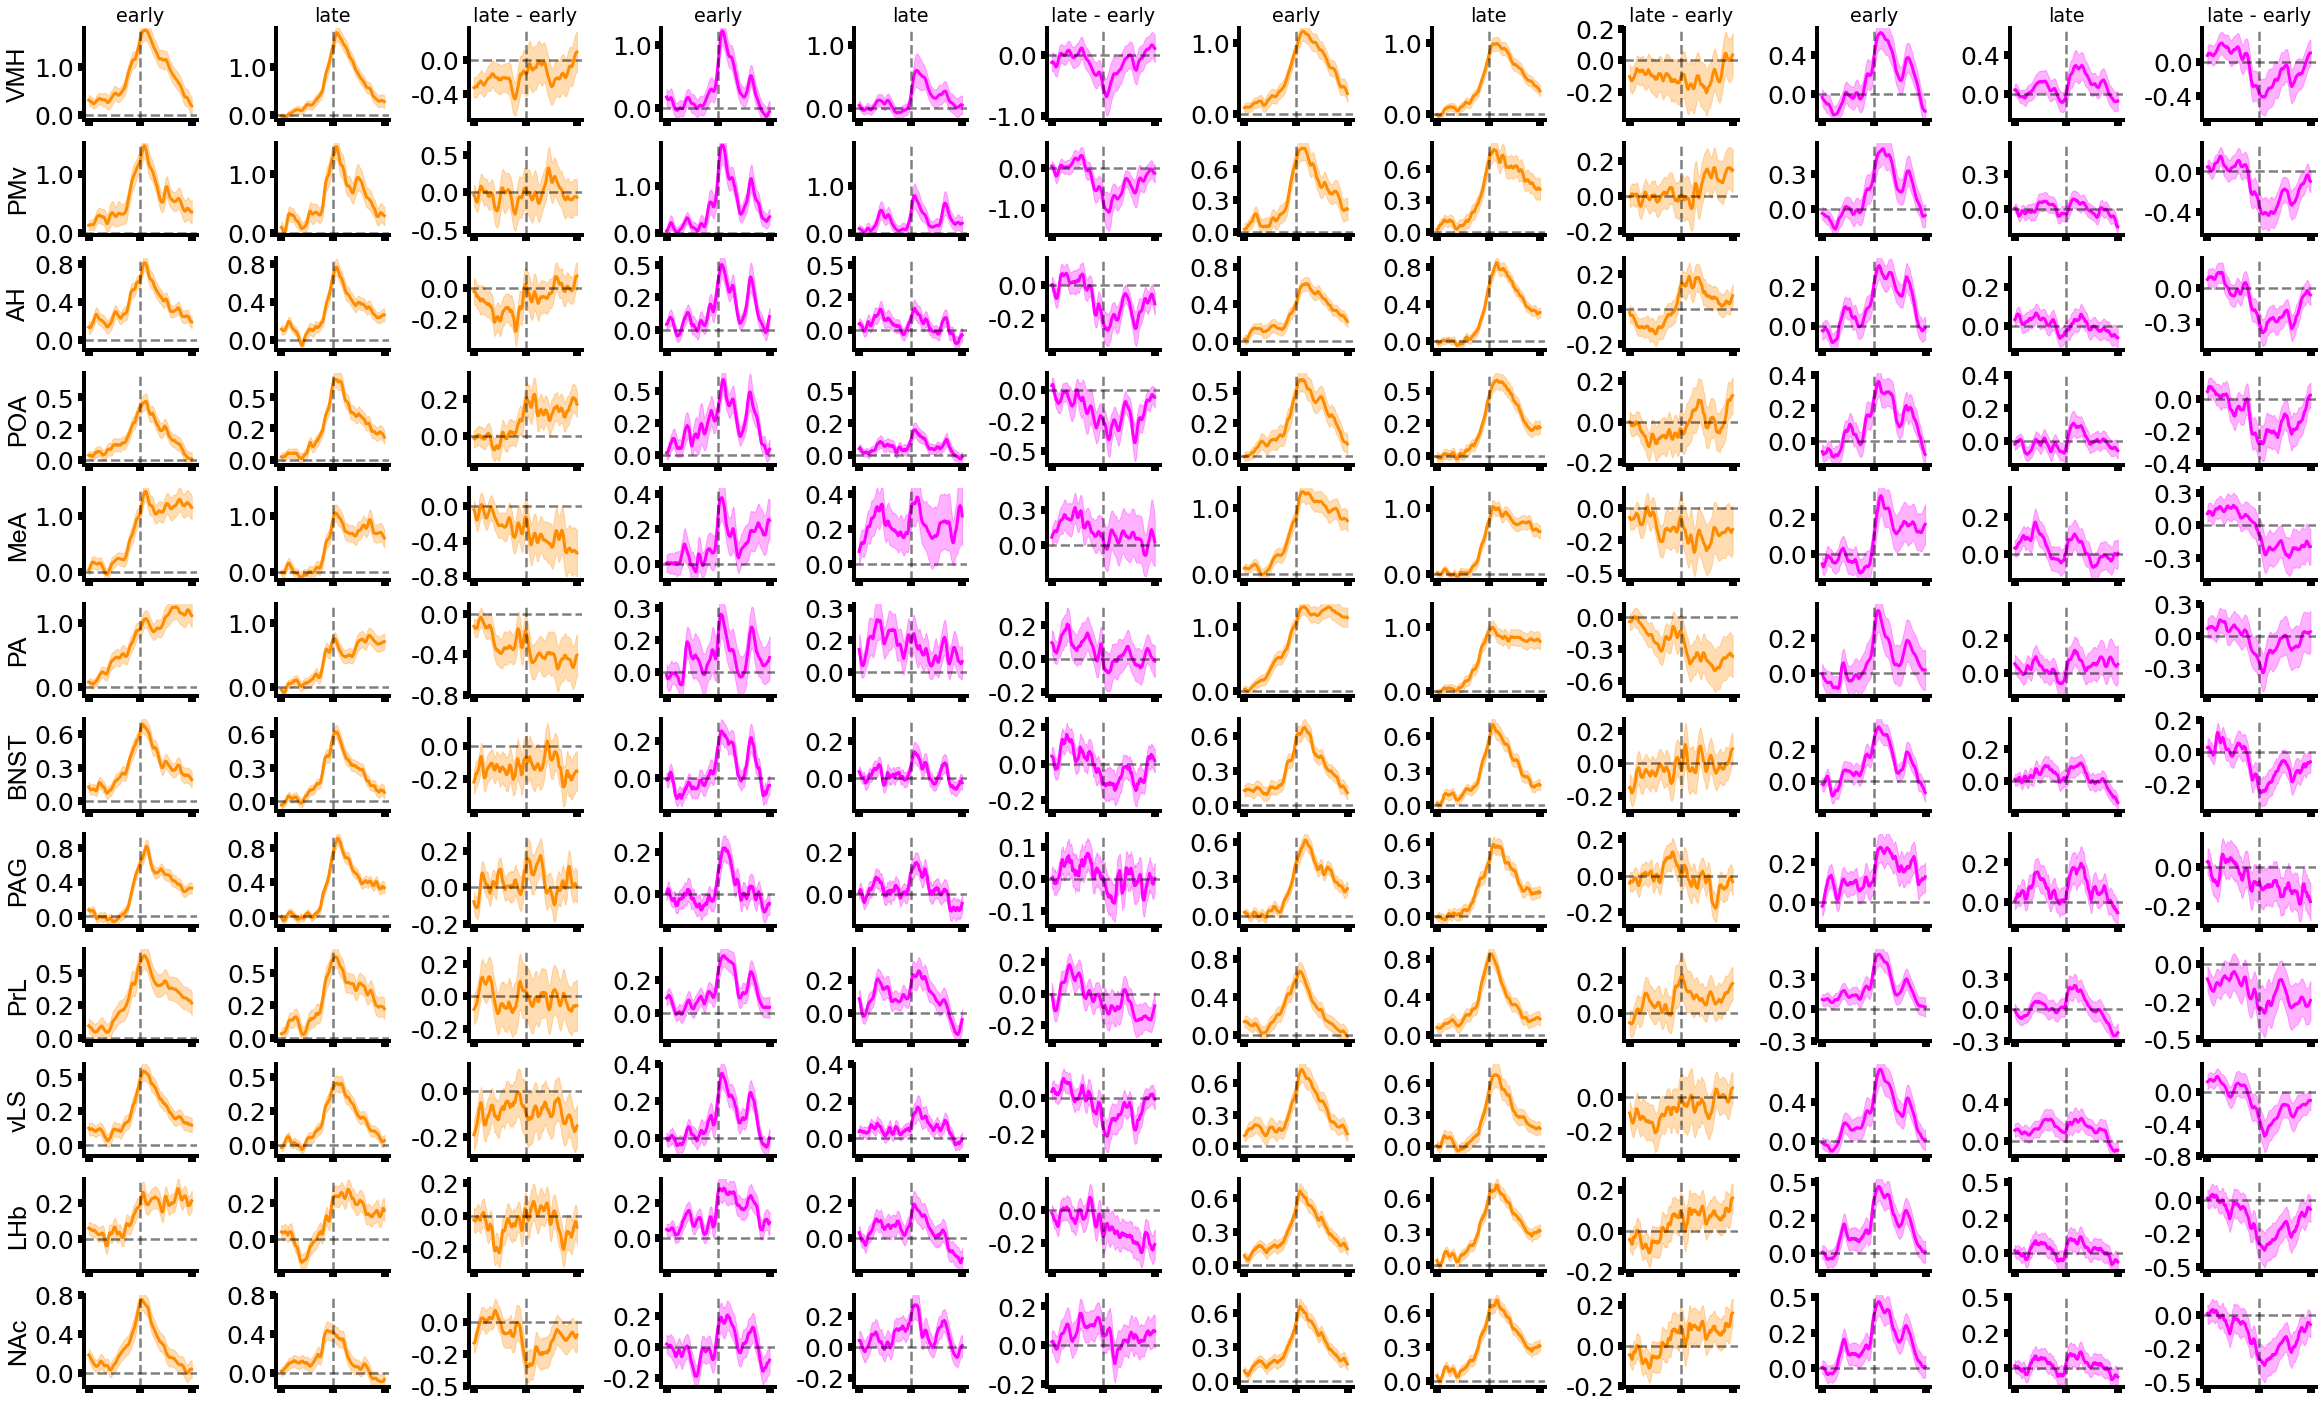

In [338]:
# plot early vs late EI peths; grouped by trial

from matplotlib.ticker import MaxNLocator
periods = [80, 400]
# periods = [0, 320]
n = periods[1] - periods[0]

fig, ax = plt.subplots(12, 12, figsize=(40, 25))
sorting = [12, 16, 8, 4, 10, 20, 6, 14, 0, 2, 18, 22]
agg_color = 'darkorange'
obs_color = 'magenta'

p_values_agg = []
p_values_obs = []

for i, r in enumerate(sorting):
    try:

        ### define data for roi

        # early
        agg_E_early = agg_peths_early_notGrouped[:, r, :] - np.nanmedian(agg_peths_early_notGrouped[:80, r, :], axis=0)
        obs_E_early = obs_peths_early_notGrouped[:, r, :] - np.nanmedian(obs_peths_early_notGrouped[:80, r, :], axis=0)
        if r != 22:
            agg_I_early = agg_peths_early_notGrouped[:, r+1, :] - np.nanmedian(agg_peths_early_notGrouped[:80, r+1, :], axis=0)
            obs_I_early = obs_peths_early_notGrouped[:, r+1, :] - np.nanmedian(obs_peths_early_notGrouped[:80, r+1, :], axis=0)

        # late
        agg_E_late = agg_peths_late_notGrouped[:, r, :] - np.nanmedian(agg_peths_late_notGrouped[:80, r, :], axis=0)
        obs_E_late = obs_peths_late_notGrouped[:, r, :] - np.nanmedian(obs_peths_late_notGrouped[:80, r, :], axis=0)
        if r != 22:
            agg_I_late = agg_peths_late_notGrouped[:, r+1, :] - np.nanmedian(agg_peths_late_notGrouped[:80, r+1, :], axis=0)
            obs_I_late = obs_peths_late_notGrouped[:, r+1, :] - np.nanmedian(obs_peths_late_notGrouped[:80, r+1, :], axis=0)

        agg_E_diff = agg_E_late - agg_E_early
        obs_E_diff = obs_E_late - obs_E_early
        if r != 22:
            agg_I_diff = agg_I_late - agg_I_early
            obs_I_diff = obs_I_late - obs_I_early
            p_values_agg.extend([run_atk_stats_vs_0(agg_E_diff[220:260]), run_atk_stats_vs_0(agg_I_diff[220:260])])
            p_values_obs.extend([run_atk_stats_vs_0(obs_E_diff[220:260]), run_atk_stats_vs_0(obs_I_diff[220:260])])
        else:
            p_values_agg.extend([run_atk_stats_vs_0(agg_E_diff[220:260])])
            p_values_obs.extend([run_atk_stats_vs_0(obs_E_diff[220:260])])

        # plot early AGG
        ax[i, 0].plot(np.nanmean(agg_E_early, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(agg_E_early, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_E_early, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E_early.shape[1]),
        np.nanmean(agg_E_early, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_E_early, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E_early.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 0].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 0].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 0].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot late AGG
        ax[i, 1].plot(np.nanmean(agg_E_late, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(agg_E_late, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_E_late, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E_late.shape[1]),
        np.nanmean(agg_E_late, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_E_late, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E_late.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 1].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 1].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 1].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # normalize AGG y-scale
        max1 = np.nanmean(agg_E_early, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(agg_E_late, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(agg_E_early, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(agg_E_late, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 0].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        ax[i, 1].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)

        # Plot E diff
        ax[i, 2].plot(np.nanmean(agg_E_diff, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color, linewidth=3)
        ax[i, 2].fill_between(range(n), np.nanmean(agg_E_diff, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_E_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E_diff.shape[1]),
        np.nanmean(agg_E_diff, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_E_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E_diff.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 2].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 2].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 2].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot early OBS
        ax[i, 3].plot(np.nanmean(obs_E_early, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 3].fill_between(range(n), np.nanmean(obs_E_early, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_E_early, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_E_early.shape[1]),
        np.nanmean(obs_E_early, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_E_early, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_E_early.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 3].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 3].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 3].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot late OBS
        ax[i, 4].plot(np.nanmean(obs_E_late, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 4].fill_between(range(n), np.nanmean(obs_E_late, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_E_late, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_E_late.shape[1]),
        np.nanmean(obs_E_late, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_E_late, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_E_late.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 4].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 4].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 4].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # normalize OBS y-scale
        max1 = np.nanmean(obs_E_early, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(obs_E_late, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(obs_E_early, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(obs_E_late, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 3].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        ax[i, 4].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        
        # plot late - early OBS
        ax[i, 5].plot(np.nanmean(obs_E_diff, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 5].fill_between(range(n), np.nanmean(obs_E_diff, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_E_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_E_diff.shape[1]),
        np.nanmean(obs_E_diff, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_E_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_E_diff.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 5].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 5].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 5].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot early AGG I
        ax[i, 6].plot(np.nanmean(agg_I_early, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color, linewidth=3)
        ax[i, 6].fill_between(range(n), np.nanmean(agg_I_early, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_I_early, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I_early.shape[1]),
        np.nanmean(agg_I_early, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_I_early, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I_early.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 6].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 6].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 6].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot late AGG I
        ax[i, 7].plot(np.nanmean(agg_I_late, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color, linewidth=3)
        ax[i, 7].fill_between(range(n), np.nanmean(agg_I_late, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_I_late, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I_late.shape[1]),
        np.nanmean(agg_I_late, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_I_late, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I_late.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 7].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 7].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 7].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # normalize AGG I y-scale
        max1 = np.nanmean(agg_I_early, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(agg_I_late, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(agg_I_early, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(agg_I_late, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 6].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        ax[i, 7].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)

        # Plot I diff
        ax[i, 8].plot(np.nanmean(agg_I_diff, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color, linewidth=3)
        ax[i, 8].fill_between(range(n), np.nanmean(agg_I_diff, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_I_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I_diff.shape[1]),
        np.nanmean(agg_I_diff, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_I_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I_diff.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 8].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 8].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 8].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot early OBS I
        ax[i, 9].plot(np.nanmean(obs_I_early, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color, linewidth=3)
        ax[i, 9].fill_between(range(n), np.nanmean(obs_I_early, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_I_early, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I_early.shape[1]),
        np.nanmean(obs_I_early, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_I_early, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I_early.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 9].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 9].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 9].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot late OBS I
        ax[i, 10].plot(np.nanmean(obs_I_late, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color, linewidth=3)
        ax[i, 10].fill_between(range(n), np.nanmean(obs_I_late, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_I_late, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I_late.shape[1]),
        np.nanmean(obs_I_late, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_I_late, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I_late.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 10].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 10].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 10].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # normalize OBS I y-scale
        max1 = np.nanmean(obs_I_early, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(obs_I_late, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(obs_I_early, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(obs_I_late, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 9].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        ax[i, 10].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)

        # Plot I diff
        ax[i, 11].plot(np.nanmean(obs_I_diff, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color, linewidth=3)
        ax[i, 11].fill_between(range(n), np.nanmean(obs_I_diff, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_I_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I_diff.shape[1]),
        np.nanmean(obs_I_diff, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_I_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I_diff.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 11].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 11].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 11].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        ax[i, 0].set_ylabel(region_ids[r].replace(' (E)', '').replace(' (I)', '').replace(' (DA)', ''), fontfamily='Arial')
        ax[i, 0].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 1].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 2].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 3].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 4].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 5].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 6].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 7].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 8].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 9].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 10].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 11].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 0].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 1].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 2].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 3].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 4].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 5].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 6].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 7].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 8].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 9].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 10].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 11].yaxis.set_major_formatter(FuncFormatter(format_func))
        sns.despine()
    except IndexError:
        continue

ax[0, 0].set_title('early')
ax[0, 1].set_title('late')
ax[0, 2].set_title('late - early')
ax[0, 3].set_title('early')
ax[0, 4].set_title('late')
ax[0, 5].set_title('late - early')
ax[0, 6].set_title('early')
ax[0, 7].set_title('late')
ax[0, 8].set_title('late - early')
ax[0, 9].set_title('early')
ax[0, 10].set_title('late')
ax[0, 11].set_title('late - early')

fig.subplots_adjust(wspace=0.7, hspace=0.25)
plt.savefig('./figures/agg_obs_non_time-dependent_PETHs.svg', dpi=300)
# plt.tight_layout()


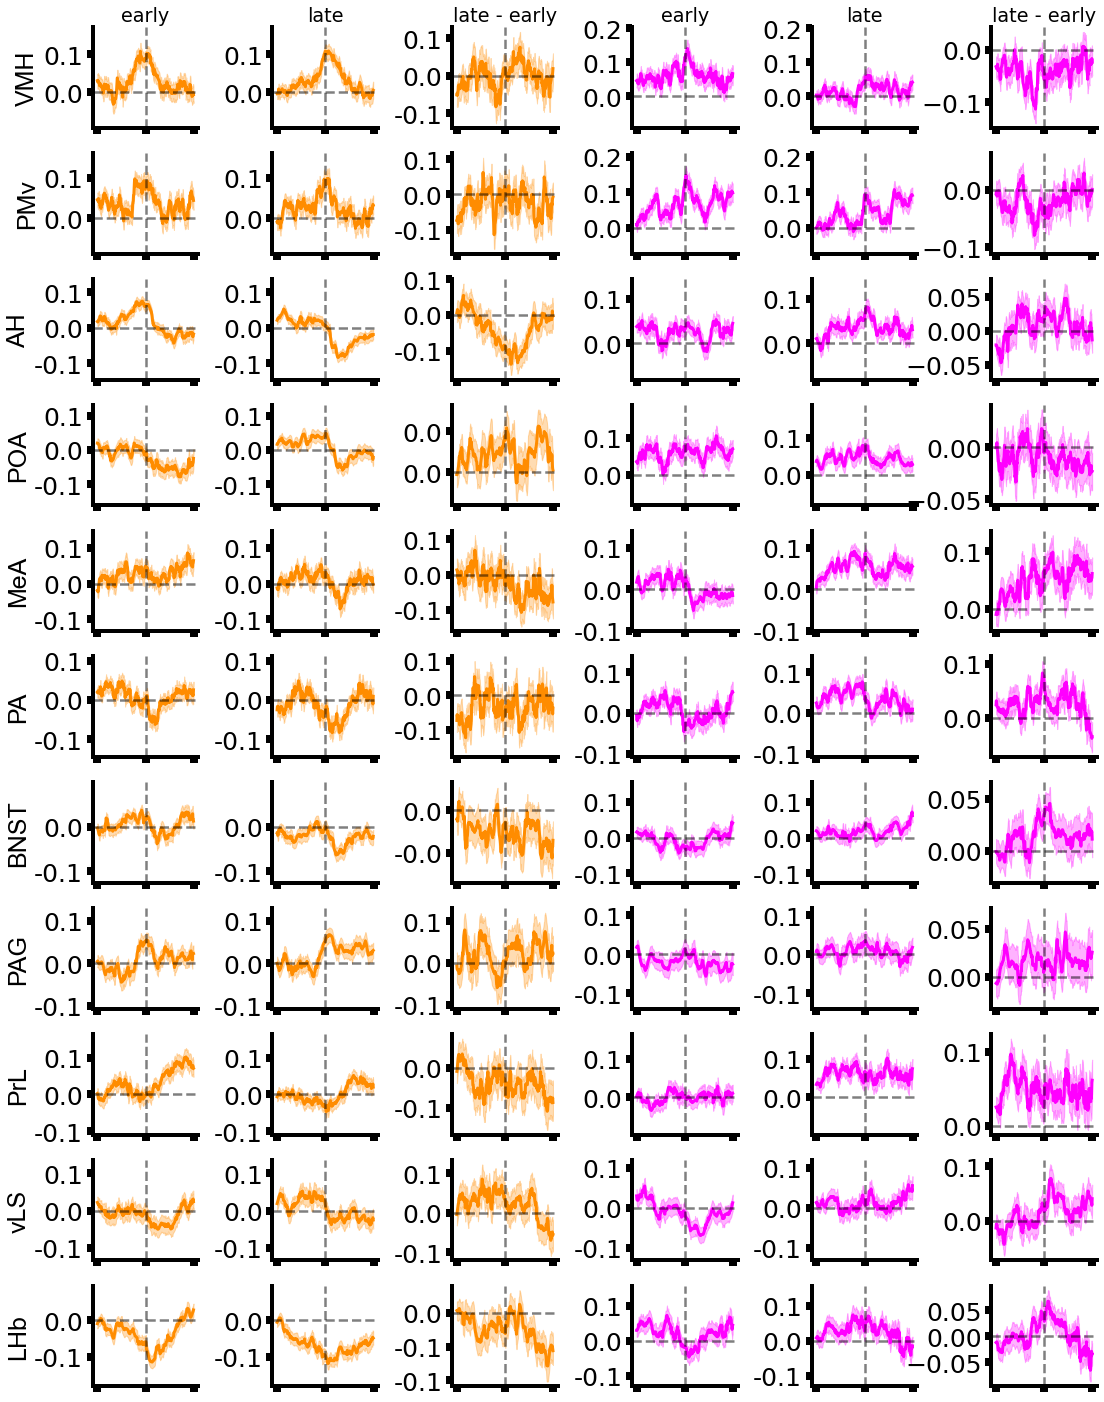

In [328]:
# plot early vs late EI peths; grouped by trial

from matplotlib.ticker import MaxNLocator
periods = [80, 400]
# periods = [0, 320]
n = periods[1] - periods[0]

fig, ax = plt.subplots(11, 6, figsize=(18, 25))
sorting = [12, 16, 8, 4, 10, 20, 6, 14, 0, 2, 18]
agg_color = 'darkorange'
obs_color = 'magenta'

for i, r in enumerate(sorting):
    try:

        ### define data for roi

        # early
        agg_E_early = agg_peths_early_notGrouped[:, r, :] - np.nanmedian(agg_peths_early_notGrouped[:80, r, :], axis=0)
        obs_E_early = obs_peths_early_notGrouped[:, r, :] - np.nanmedian(obs_peths_early_notGrouped[:80, r, :], axis=0)
        agg_I_early = agg_peths_early_notGrouped[:, r+1, :] - np.nanmedian(agg_peths_early_notGrouped[:80, r+1, :], axis=0)
        obs_I_early = obs_peths_early_notGrouped[:, r+1, :] - np.nanmedian(obs_peths_early_notGrouped[:80, r+1, :], axis=0)

        # late
        agg_E_late = agg_peths_late_notGrouped[:, r, :] - np.nanmedian(agg_peths_late_notGrouped[:80, r, :], axis=0)
        obs_E_late = obs_peths_late_notGrouped[:, r, :] - np.nanmedian(obs_peths_late_notGrouped[:80, r, :], axis=0)
        agg_I_late = agg_peths_late_notGrouped[:, r+1, :] - np.nanmedian(agg_peths_late_notGrouped[:80, r+1, :], axis=0)
        obs_I_late = obs_peths_late_notGrouped[:, r+1, :] - np.nanmedian(obs_peths_late_notGrouped[:80, r+1, :], axis=0)

        # map E-I differences
        agg_EI_early = (agg_E_early - agg_I_early) / (agg_E_early + agg_I_early + 4)
        agg_EI_early[np.abs(agg_EI_early) > 1] = np.nan
        obs_EI_early = (obs_E_early - obs_I_early) / (obs_E_early + obs_I_early + 4)
        obs_EI_early[np.abs(obs_EI_early) > 1] = np.nan
        agg_EI_late = (agg_E_late - agg_I_late) / (agg_E_late + agg_I_late + 4)
        agg_EI_late[np.abs(agg_EI_late) > 1] = np.nan
        obs_EI_late = (obs_E_late - obs_I_late) / (obs_E_late + obs_I_late + 4)
        obs_EI_late[np.abs(obs_EI_late) > 1] = np.nan

        # E-I late - early
        agg_EI_diff = agg_EI_late - agg_EI_early
        obs_EI_diff = obs_EI_late - obs_EI_early

        # plot early AGG
        ax[i, 0].plot(np.nanmean(agg_EI_early, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(agg_EI_early, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_EI_early, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI_early.shape[1]),
        np.nanmean(agg_EI_early, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_EI_early, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI_early.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 0].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 0].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 0].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot late AGG
        ax[i, 1].plot(np.nanmean(agg_EI_late, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(agg_EI_late, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_EI_late, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI_late.shape[1]),
        np.nanmean(agg_EI_late, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_EI_late, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI_late.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 1].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 1].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 1].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # normalize AGG y-scale
        max1 = np.nanmean(agg_EI_early, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(agg_EI_late, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(agg_EI_early, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(agg_EI_late, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 0].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        ax[i, 1].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)

        # plot late - early
        ax[i, 2].plot(np.nanmean(agg_EI_diff, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 2].fill_between(range(n), np.nanmean(agg_EI_diff, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_EI_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI_diff.shape[1]),
        np.nanmean(agg_EI_diff, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_EI_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI_diff.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 2].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 2].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 2].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot early OBS
        ax[i, 3].plot(np.nanmean(obs_EI_early, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 3].fill_between(range(n), np.nanmean(obs_EI_early, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_EI_early, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI_early.shape[1]),
        np.nanmean(obs_EI_early, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_EI_early, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI_early.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 3].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 3].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 3].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # plot late OBS
        ax[i, 4].plot(np.nanmean(obs_EI_late, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 4].fill_between(range(n), np.nanmean(obs_EI_late, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_EI_late, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI_late.shape[1]),
        np.nanmean(obs_EI_late, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_EI_late, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI_late.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 4].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 4].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, 4].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        # normalize OBS y-scale
        max1 = np.nanmean(obs_EI_early, axis=1)[periods[0]:periods[1]].max()
        max2 = np.nanmean(obs_EI_late, axis=1)[periods[0]:periods[1]].max()
        min1 = np.nanmean(obs_EI_early, axis=1)[periods[0]:periods[1]].min()
        min2 = np.nanmean(obs_EI_late, axis=1)[periods[0]:periods[1]].min()
        ylim_top = max(max1, max2)
        ylim_bottom = min(min1, min2)
        ax[i, 3].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        ax[i, 4].set_ylim(bottom=ylim_bottom-0.05, top=ylim_top+0.05)
        
        # plot late - early OBS
        ax[i, -1].plot(np.nanmean(obs_EI_diff, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, -1].fill_between(range(n), np.nanmean(obs_EI_diff, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_EI_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI_diff.shape[1]),
        np.nanmean(obs_EI_diff, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_EI_diff, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI_diff.shape[1]), alpha=0.3, color=obs_color)
        ax[i, -1].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, -1].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[i, -1].set_xticks(np.arange(0, 480, 480/3), ['', '', ''])

        ax[i, 0].set_ylabel(region_ids[r].replace(' (E)', '').replace(' (I)', '').replace(' (DA)', ''), fontfamily='Arial')
        ax[i, 0].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 1].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 2].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 3].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 4].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        ax[i, 0].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 1].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 2].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 3].yaxis.set_major_formatter(FuncFormatter(format_func))
        ax[i, 4].yaxis.set_major_formatter(FuncFormatter(format_func))

        sns.despine()
    except IndexError:
        continue

ax[0, 0].set_title('early')
ax[0, 1].set_title('late')
ax[0, 2].set_title('late - early')
ax[0, 3].set_title('early')
ax[0, 4].set_title('late')
ax[0, -1].set_title('late - early')

fig.subplots_adjust(wspace=0.7, hspace=0.25)
plt.savefig('./figures/agg_obs_non_peths_TW_wEI.svg', dpi=300)
# plt.tight_layout()


7. Evaluate LHb vs NAc signals on a trial by trial basis:

In [257]:
from matplotlib.colors import LinearSegmentedColormap
# Define the colormap
colors = [(0, 1, 0), (0, 0, 0), (0.9, 0.9, 0.9)]  # Black to white to green
n_bins = 100  # Number of bins in the colormap
cmap_name = 'black_white_green'

# Create the colormap
black_green_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

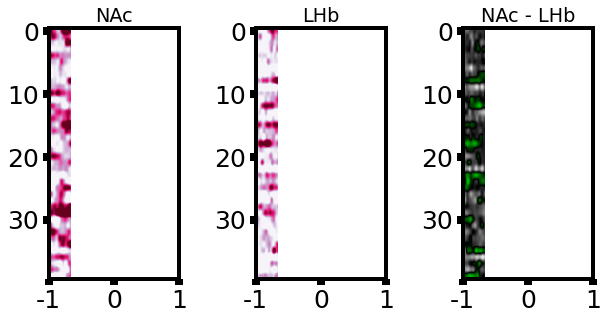

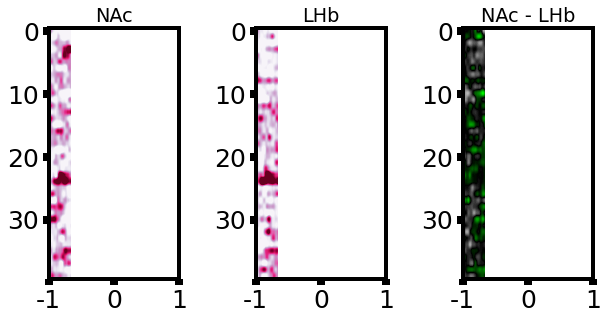

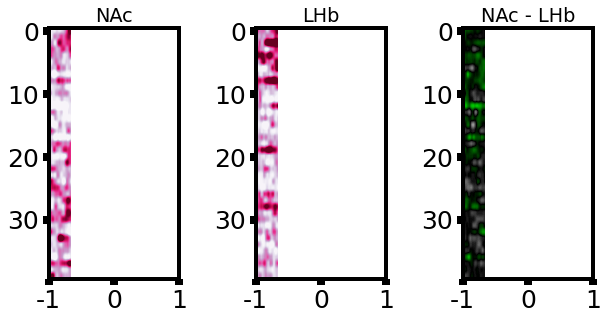

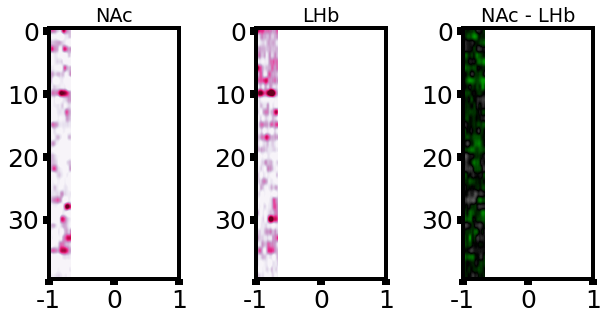

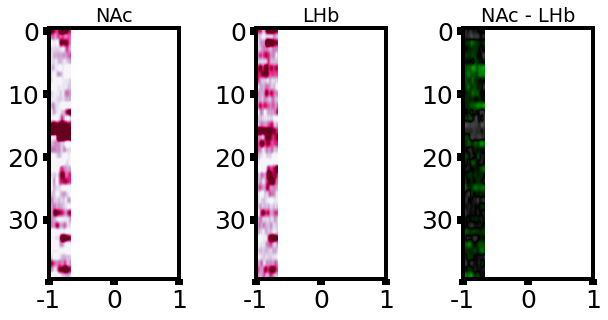

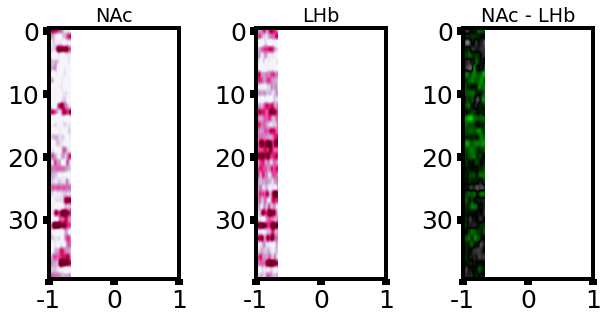

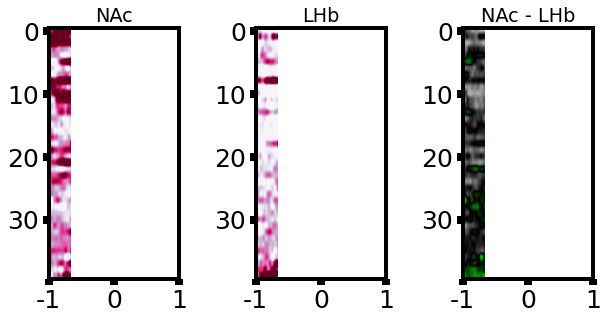

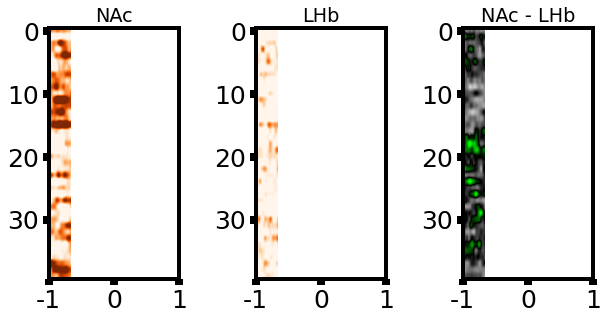

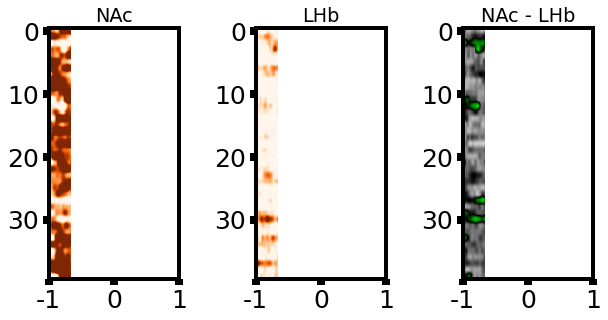

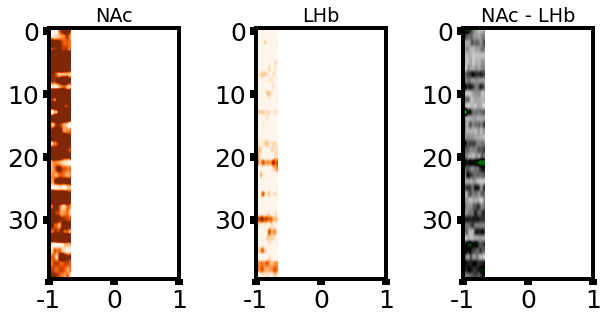

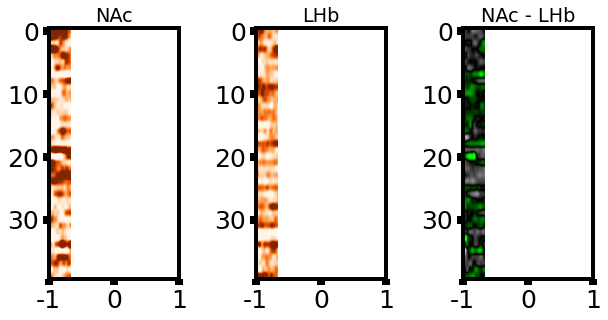

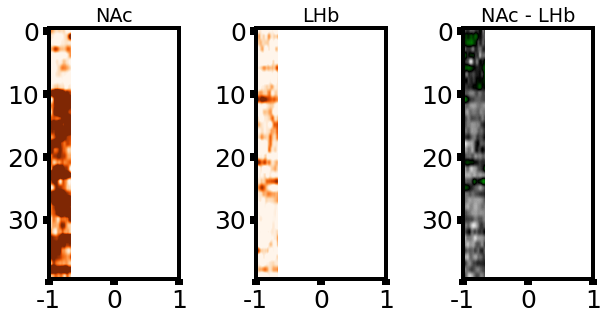

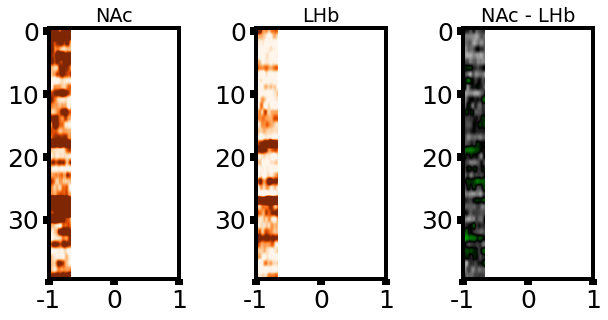

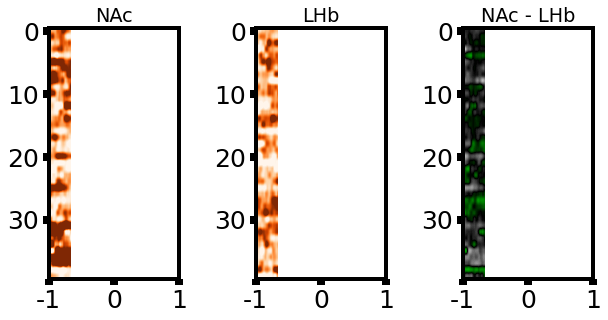

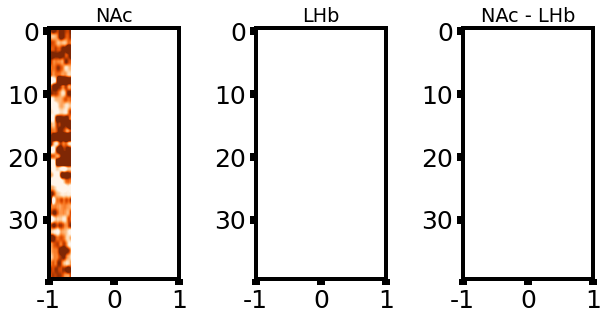

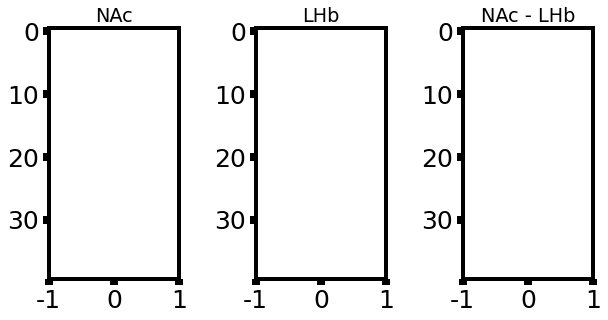

In [265]:
n = 480
obs_selectivity = []
obs_sensitivity_distribution = []
for mouse in TW_obs_dict.keys():
    photometry = TW_obs_dict[mouse]
    NAc = photometry[:,200:280, -1][:40]
    LHb = photometry[:,200:280, 18][:40]
    selectivity = (NAc - LHb) / (NAc + LHb + 2)
    obs_sensitivity_distribution.append(selectivity)
    mean_selectivity = np.median(selectivity)
    obs_selectivity.append(mean_selectivity)
    fig, ax = plt.subplots(1, 3, figsize=(9, 5))
    ax[0].imshow(NAc, aspect='auto', cmap='PuRd', vmin=-0, vmax=2)
    ax[0].set_title('NAc')
    ax[0].set_xticks(np.arange(0, n+n/2, n/2), [-1, 0, 1])
    ax[1].imshow(LHb, aspect='auto', cmap='PuRd', vmin=-0, vmax=2)
    ax[1].set_title('LHb')
    ax[1].set_xticks(np.arange(0, n+n/2, n/2), [-1, 0, 1])
    ax[2].imshow(selectivity, aspect='auto', cmap=black_green_cmap, vmin=-1, vmax=1)
    ax[2].set_title('NAc - LHb')
    ax[2].set_xticks(np.arange(0, n+n/2, n/2), [-1, 0, 1])
    plt.tight_layout()
    # plt.savefig(f'./figures/obs_selectivity_{mouse}.svg', dpi=300)

agg_selectivity = []
agg_sensitivity_distribution = []
for mouse in TW_agg_dict.keys():
    photometry = TW_agg_dict[mouse]
    NAc = photometry[:,200:280, -1][:40]
    LHb = photometry[:,200:280, 18][:40]
    selectivity = (NAc - LHb) / (NAc + LHb + 2)
    agg_sensitivity_distribution.append(selectivity)
    mean_selectivity = np.median(selectivity)
    agg_selectivity.append(mean_selectivity)
    fig, ax = plt.subplots(1, 3, figsize=(9, 5))
    ax[0].imshow(NAc, aspect='auto', cmap='Oranges', vmin=-0, vmax=2)
    ax[0].set_title('NAc')
    ax[0].set_xticks(np.arange(0, n+n/2, n/2), [-1, 0, 1])
    ax[1].imshow(LHb, aspect='auto', cmap='Oranges', vmin=-0, vmax=2)
    ax[1].set_title('LHb')
    ax[1].set_xticks(np.arange(0, n+n/2, n/2), [-1, 0, 1])
    ax[2].imshow(selectivity, aspect='auto', cmap=black_green_cmap, vmin=-1, vmax=1)
    ax[2].set_title('NAc - LHb')
    ax[2].set_xticks(np.arange(0, n+n/2, n/2), [-1, 0, 1])
    plt.tight_layout()
    # plt.savefig(f'./figures/agg_selectivity_{mouse}.svg', dpi=300)

t-test p-value: 0.007995404531070662
t =  3.17497695793007
KS test p-value: 0.0
KS =  0.3495089285714285


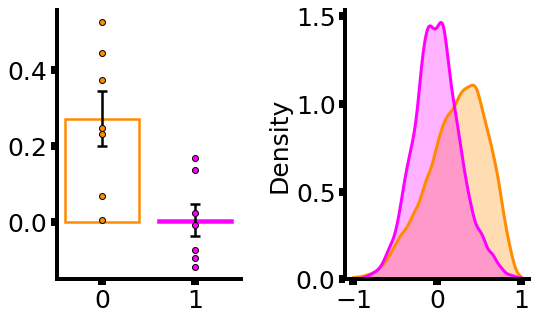

In [413]:
from scipy.stats import sem, ks_2samp, ttest_ind

bar_settings = {
    'color': 'white',
    'linewidth': 2.5,
    'error_kw': {'elinewidth': 2.5, 'capsize': 5, 'capthick': 2.5}
}

### barplot

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].bar(0, np.nanmean(agg_selectivity), yerr=sem(agg_selectivity, nan_policy='omit'), edgecolor='darkorange',**bar_settings)
ax[0].bar(1, np.nanmean(obs_selectivity), yerr=sem(obs_selectivity, nan_policy='omit'), edgecolor='magenta', **bar_settings)

# Plot individual data points
ax[0].scatter(np.full_like(agg_selectivity, 0), agg_selectivity, color='darkorange', edgecolor='black', zorder=2)
ax[0].scatter(np.full_like(obs_selectivity, 1), obs_selectivity, color='magenta', edgecolor='black', zorder=2)

tt, tp = ttest_ind(agg_selectivity, obs_selectivity, nan_policy='omit')
print('t-test p-value:', tp)
print('t = ', tt)

### distb

flattened_agg = np.concatenate(agg_sensitivity_distribution).flatten()
flattened_agg = flattened_agg[~np.isnan(flattened_agg)]
flattened_obs = np.concatenate(obs_sensitivity_distribution).flatten()
flattened_obs = flattened_obs[~np.isnan(flattened_obs)]

sns.kdeplot(flattened_agg, ax=ax[1], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0, clip=(-1,1))
sns.kdeplot(flattened_agg, ax=ax[1], color='darkorange', lw=3, clip=(-1,1))
sns.kdeplot(flattened_obs, ax=ax[1], color='magenta', multiple='layer', fill=True, alpha=0.3, lw=0, clip=(-1,1))
sns.kdeplot(flattened_obs, ax=ax[1], color='magenta', lw=3, clip=(-1,1))


sns.despine()
plt.tight_layout()

ks, ksp = ks_2samp(flattened_agg, flattened_obs) 
print('KS test p-value:', ksp)
print('KS = ', ks)
plt.savefig('./figures/selectivity_comparison.svg', dpi=300)

8. Evaluating whether peak timing relative to behavior changes over time

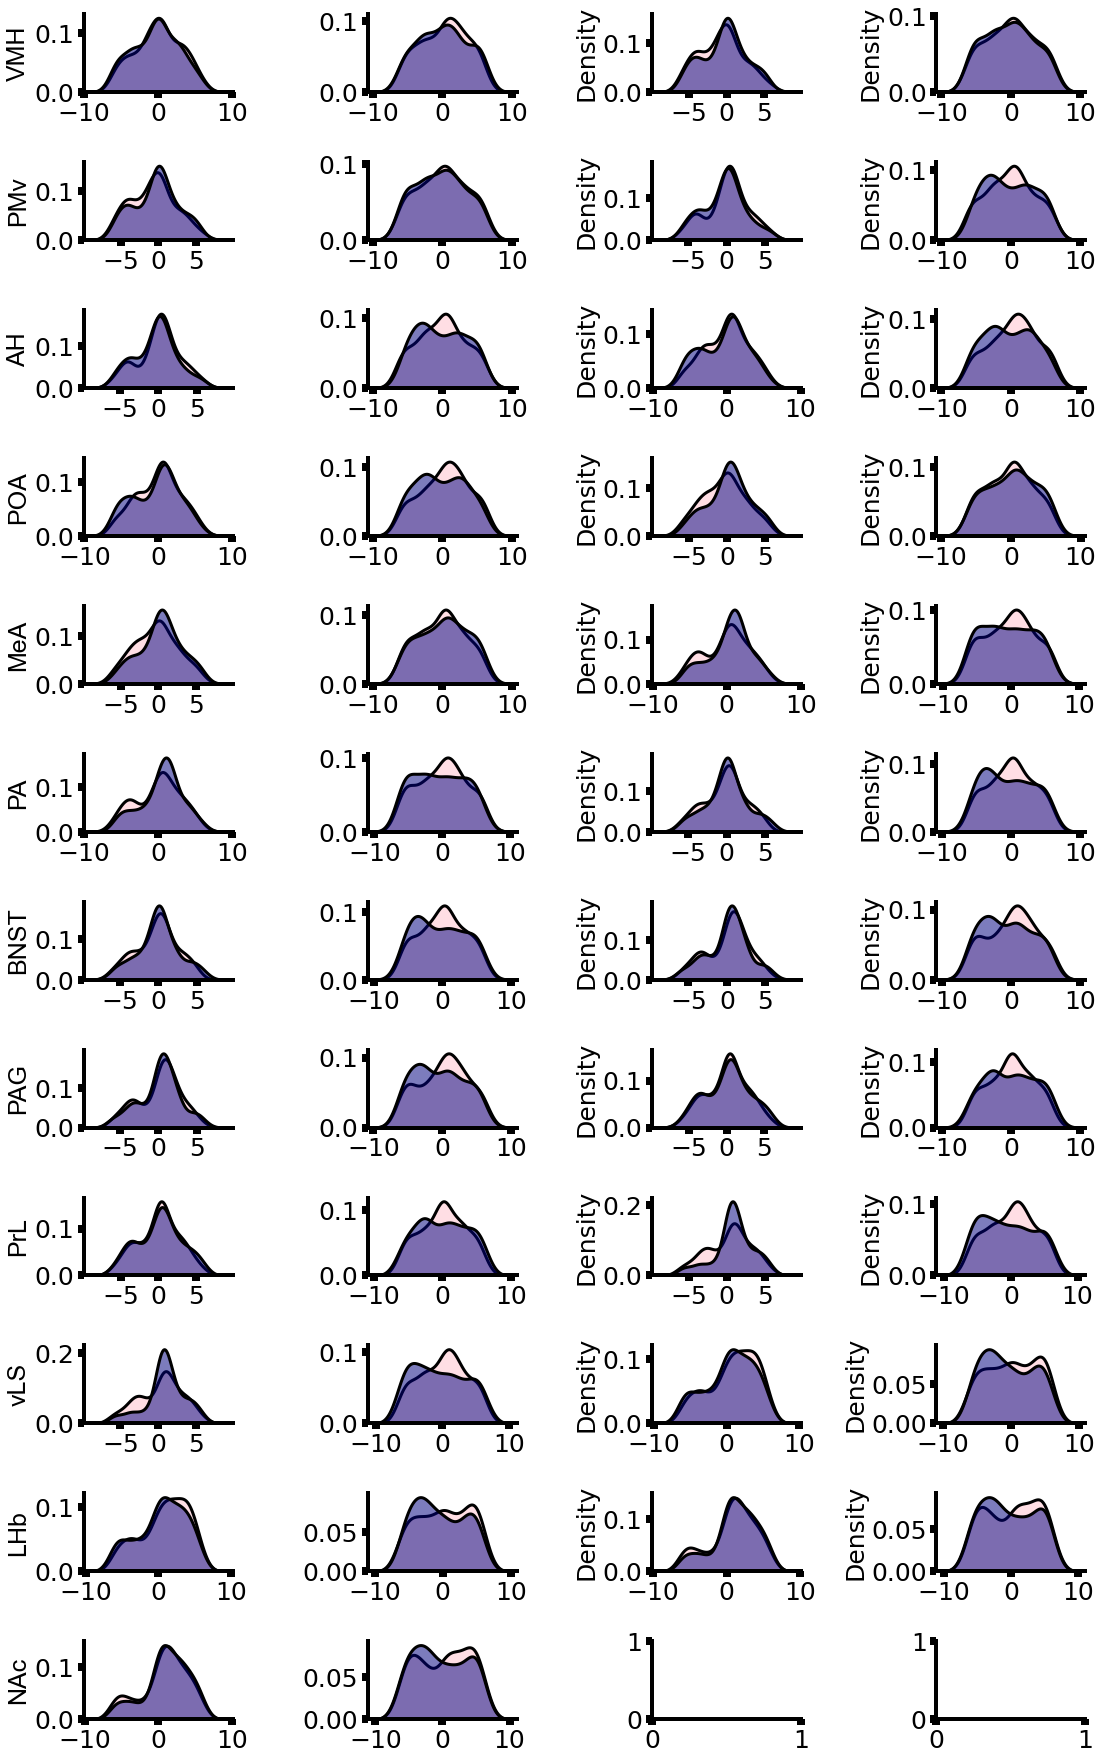

In [348]:
# fig, ax = plt.subplots(11, 6, figsize=(18, 25))
sorting = [12, 16, 8, 4, 10, 20, 6, 14, 0, 2, 18, 22]
agg_color = 'darkorange'
obs_color = 'magenta'
time_period = [0, None]
from scipy.stats import ks_2samp

def grab_distb(array, funct):
    distrib = []
    for i in range(array.shape[1]):
        sample = array[:, i]
        if not np.any(np.isnan(sample)):
            distrib.append(funct(sample))
        else:
            continue
    distrib = (np.array(distrib)-240)/40
    return distrib
p_values_agg = []
p_values_obs = []
function = np.argmax
fig, ax = plt.subplots(12, 4, figsize=(16, 25))
for r, region in enumerate(sorting):
    try:

        ### define data for roi

        # early
        agg_E_early = agg_peths_early_notGrouped[:, r, :] - np.nanmedian(agg_peths_early_notGrouped[:80, r, :], axis=0)
        obs_E_early = obs_peths_early_notGrouped[:, r, :] - np.nanmedian(obs_peths_early_notGrouped[:80, r, :], axis=0)
        if region != 22:
            agg_I_early = agg_peths_early_notGrouped[:, r+1, :] - np.nanmedian(agg_peths_early_notGrouped[:80, r+1, :], axis=0)
            obs_I_early = obs_peths_early_notGrouped[:, r+1, :] - np.nanmedian(obs_peths_early_notGrouped[:80, r+1, :], axis=0)

        # late
        agg_E_late = agg_peths_late_notGrouped[:, r, :] - np.nanmedian(agg_peths_late_notGrouped[:80, r, :], axis=0)
        obs_E_late = obs_peths_late_notGrouped[:, r, :] - np.nanmedian(obs_peths_late_notGrouped[:80, r, :], axis=0)
        if region != 22:
            agg_I_late = agg_peths_late_notGrouped[:, r+1, :] - np.nanmedian(agg_peths_late_notGrouped[:80, r+1, :], axis=0)
            obs_I_late = obs_peths_late_notGrouped[:, r+1, :] - np.nanmedian(obs_peths_late_notGrouped[:80, r+1, :], axis=0)

        # lock time period
        agg_E_early = agg_E_early[time_period[0]:time_period[1], :]
        obs_E_early = obs_E_early[time_period[0]:time_period[1], :]
        agg_E_late = agg_E_late[time_period[0]:time_period[1], :]
        obs_E_late = obs_E_late[time_period[0]:time_period[1], :]
        if region != 22:
            agg_I_early = agg_I_early[time_period[0]:time_period[1], :]
            obs_I_early = obs_I_early[time_period[0]:time_period[1], :]
            agg_I_late = agg_I_late[time_period[0]:time_period[1], :]
            obs_I_late = obs_I_late[time_period[0]:time_period[1], :]

        # define distributions
        distb_agg_E_early = grab_distb(agg_E_early, funct=function)
        distb_obs_E_early = grab_distb(obs_E_early, funct=function)
        distb_agg_E_late = grab_distb(agg_E_late, funct=function)
        distb_obs_E_late = grab_distb(obs_E_late, funct=function)
        if region != 22:
            distb_agg_I_early = grab_distb(agg_I_early, funct=function)
            distb_obs_I_early = grab_distb(obs_I_early, funct=function)
            distb_agg_I_late = grab_distb(agg_I_late, funct=function)
            distb_obs_I_late = grab_distb(obs_I_late, funct=function)

        ### plot distributions

        # agg E
        sns.kdeplot(distb_agg_E_early, ax=ax[r, 0], color='pink', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
        sns.kdeplot(distb_agg_E_early, ax=ax[r, 0], color='pink', multiple='stack', lw=3, alpha=0.3)
        sns.kdeplot(distb_agg_E_late, ax=ax[r, 0], color='navy', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
        sns.kdeplot(distb_agg_E_late, ax=ax[r, 0], color='navy', multiple='stack', lw=3, alpha=0.3)
        ax[r, 0].set_ylabel(region_ids[region].replace(' (E)', '').replace(' (I)', '').replace(' (DA)', ''), fontfamily='Arial')

        # obs E
        sns.kdeplot(distb_obs_E_early, ax=ax[r, 1], color='pink', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
        sns.kdeplot(distb_obs_E_early, ax=ax[r, 1], color='pink', multiple='stack', lw=3, alpha=0.3)
        sns.kdeplot(distb_obs_E_late, ax=ax[r, 1], color='navy', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
        sns.kdeplot(distb_obs_E_late, ax=ax[r, 1], color='navy', multiple='stack', lw=3, alpha=0.3)
        ax[r, 1].set_ylabel('')

        if region != 22:

            # agg I
            sns.kdeplot(distb_agg_I_early, ax=ax[r, 2], color='pink', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
            sns.kdeplot(distb_agg_I_early, ax=ax[r, 2], color='pink', multiple='stack', lw=3, alpha=0.3)
            sns.kdeplot(distb_agg_I_late, ax=ax[r, 2], color='navy', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
            sns.kdeplot(distb_agg_I_late, ax=ax[r, 2], color='navy', multiple='stack', lw=3, alpha=0.3)

            # obs I
            sns.kdeplot(distb_obs_I_early, ax=ax[r, 3], color='pink', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
            sns.kdeplot(distb_obs_I_early, ax=ax[r, 3], color='pink', multiple='stack', lw=3, alpha=0.3)
            sns.kdeplot(distb_obs_I_late, ax=ax[r, 3], color='navy', multiple='stack', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
            sns.kdeplot(distb_obs_I_late, ax=ax[r, 3], color='navy', multiple='stack', lw=3, alpha=0.3)

        ks_statistic, p_value1 = ks_2samp(distb_agg_E_early, distb_agg_E_late)
        if region != 22:
            ks_statistic, p_value2 = ks_2samp(distb_agg_I_early, distb_agg_I_late)
        ks_statistic, p_value3 = ks_2samp(distb_obs_E_early, distb_obs_E_late)
        if region !=22:
            ks_statistic, p_value4 = ks_2samp(distb_obs_I_early, distb_obs_I_late)
        p_values_agg.extend([p_value1, p_value2])
        p_values_obs.extend([p_value3, p_value4])

    except ValueError:
        continue

    plt.tight_layout()
sns.despine()

### Hard fight

In [12]:
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests

1. Load data

In [382]:
HF_agg_dict = pd.read_pickle('time-warped_agg_data_HF.pickle')
HF_obs_dict = pd.read_pickle('time-warped_obs_data_HF.pickle')
HF_non_dict = pd.read_pickle('time-warped_non_data_HF.pickle')

2. Wrangle

In [383]:
# format into 3d matrices (window x region x animal

agg_peths_hf = np.zeros((600, len(region_ids), len(HF_agg_dict.keys())))
for k, key in enumerate(HF_agg_dict.keys()):
    peths = np.nanmean(HF_agg_dict[key], axis=0)
    agg_peths_hf[:, :, k] = peths

obs_peths_hf = np.zeros((600, len(region_ids), len(HF_obs_dict.keys())))
for k, key in enumerate(HF_obs_dict.keys()):
    peths = np.nanmean(HF_obs_dict[key], axis=0)
    obs_peths_hf[:, :, k] = peths

non_peths_hf = np.zeros((600, len(region_ids), len(HF_non_dict.keys())))
for k, key in enumerate(HF_non_dict.keys()):
    peths = np.nanmean(HF_non_dict[key], axis=0)
    non_peths_hf[:, :, k] = peths

In [384]:
agg_peths_hf_notGrouped = []
for k, key in enumerate(HF_agg_dict.keys()):
    peths = HF_agg_dict[key]
    agg_peths_hf_notGrouped.append(peths)
agg_peths_hf_notGrouped = np.transpose(np.concatenate(agg_peths_hf_notGrouped, axis=0), [1, 2, 0])

obs_peths_hf_notGrouped = []
for k, key in enumerate(HF_obs_dict.keys()):
    peths = HF_obs_dict[key]
    obs_peths_hf_notGrouped.append(peths)
obs_peths_hf_notGrouped = np.transpose(np.concatenate(obs_peths_hf_notGrouped, axis=0), [1, 2, 0])

non_peths_hf_notGrouped = []
for k, key in enumerate(HF_non_dict.keys()):
    peths = HF_non_dict[key]
    non_peths_hf_notGrouped.append(peths)
non_peths_hf_notGrouped = np.transpose(np.concatenate(non_peths_hf_notGrouped, axis=0), [1, 2, 0])

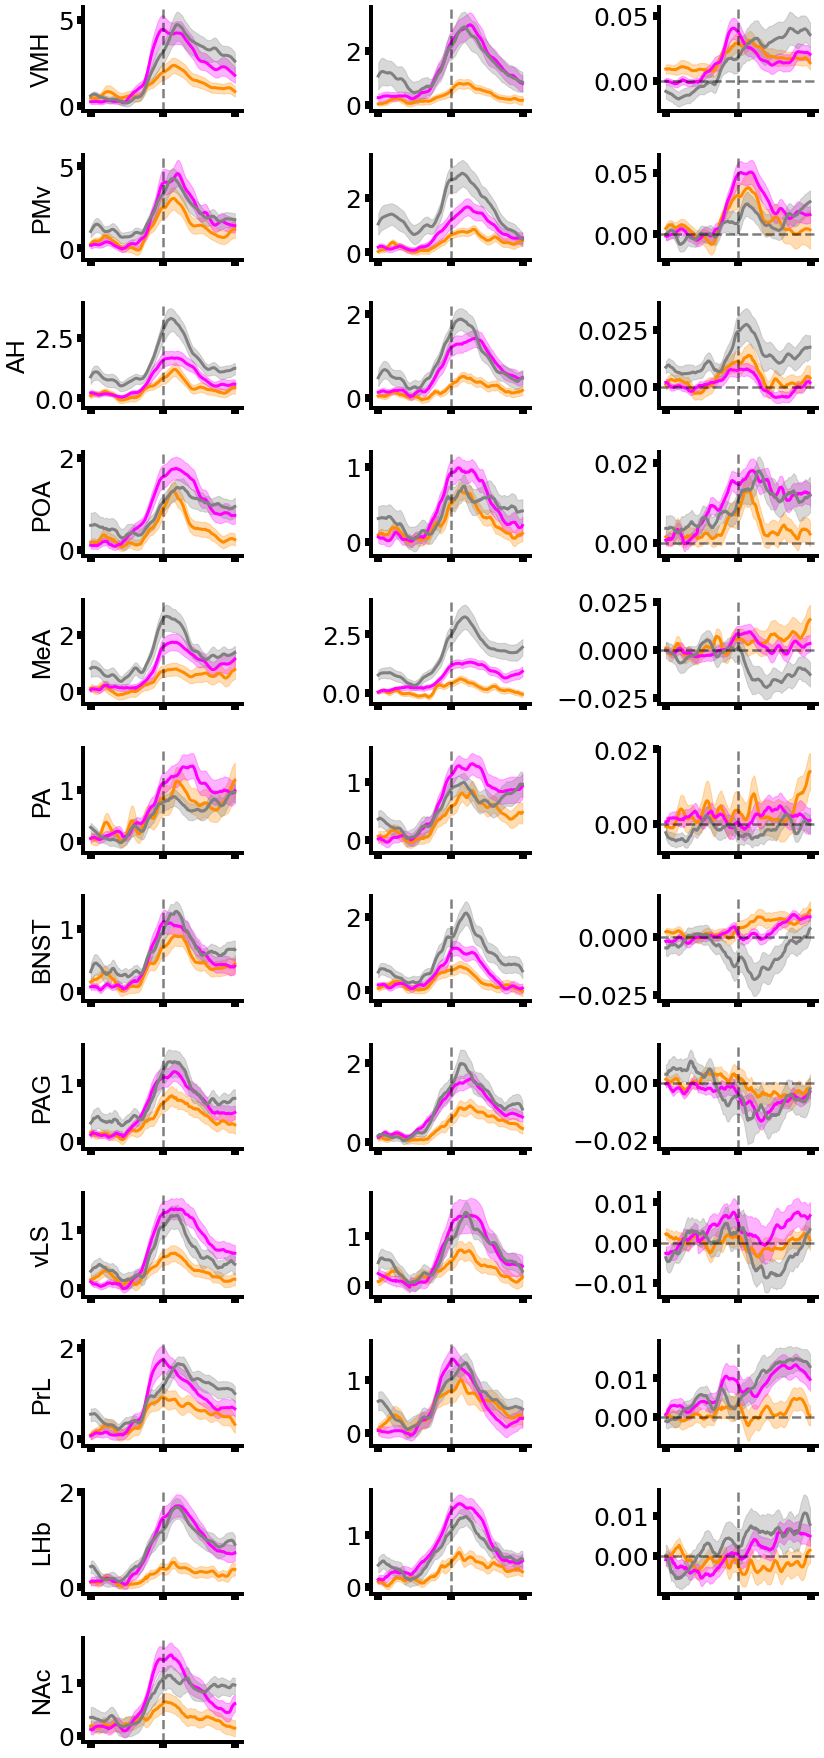

In [95]:
# plot individually averaged PETHs

from matplotlib.ticker import MaxNLocator
periods = [180, 420] # -3s to 3s
n = periods[1] - periods[0]
fig, ax = plt.subplots(12, 3, figsize=(12, 25))
sorting = [12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 22] 
agg_color = 'darkorange'
obs_color = 'magenta'
non_color='gray'

for i, r in enumerate(sorting):
    try:

        # plot exc.
        agg_E = agg_peths_hf_notGrouped[:, r, :] - np.nanmedian(agg_peths_hf_notGrouped[100:180, r, :], axis=0)
        obs_E = obs_peths_hf_notGrouped[:, r, :] - np.nanmedian(obs_peths_hf_notGrouped[100:180, r, :], axis=0)
        non_E = non_peths_hf_notGrouped[:, r, :] - np.nanmedian(non_peths_hf_notGrouped[100:180, r, :], axis=0)
        ax[i, 0].plot(np.nanmean(agg_E, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color, 
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(agg_E, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_E, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E.shape[1]),
        np.nanmean(agg_E, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_E, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 0].plot(np.nanmean(obs_E, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(obs_E, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_E, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_E.shape[1]),
        np.nanmean(obs_E, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_E, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 0].plot(np.nanmean(non_E, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[i, 0].fill_between(range(n), np.nanmean(non_E, axis=1)[periods[0]:periods[1]] - np.nanstd(non_E, axis=1)[periods[0]:periods[1]]/np.sqrt(non_E.shape[1]),
        np.nanmean(non_E, axis=1)[periods[0]:periods[1]] + np.nanstd(non_E, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_E.shape[1]), alpha=0.3, color=non_color)
        ax[i, 0].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 0].set_xticks(np.arange(0, n+n/2, n/2), ['', '', ''])
        ax[i, 0].set_ylabel(region_ids[r].replace(' (E)', '').replace(' (I)', '').replace(' (DA)', ''), fontfamily='Arial')
        # plot inh.
        agg_I = agg_peths_hf_notGrouped[:, r+1, :] - np.nanmedian(agg_peths_hf_notGrouped[100:180, r+1, :], axis=0)
        obs_I = obs_peths_hf_notGrouped[:, r+1, :] - np.nanmedian(obs_peths_hf_notGrouped[100:180, r+1, :], axis=0)
        non_I = non_peths_hf_notGrouped[:, r+1, :] - np.nanmedian(non_peths_hf_notGrouped[100:180, r+1, :], axis=0)
        ax[i, 1].plot(np.nanmean(agg_I, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(agg_I, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_I, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I.shape[1]),
        np.nanmean(agg_I, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_I, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_I.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 1].plot(np.nanmean(obs_I, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(obs_I, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_I, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I.shape[1]),
        np.nanmean(obs_I, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_I, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_I.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 1].plot(np.nanmean(non_I, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[i, 1].fill_between(range(n), np.nanmean(non_I, axis=1)[periods[0]:periods[1]] - np.nanstd(non_I, axis=1)[periods[0]:periods[1]]/np.sqrt(non_I.shape[1]),
        np.nanmean(non_I, axis=1)[periods[0]:periods[1]] + np.nanstd(non_I, axis=1)[periods[0]:periods[1]]/np.sqrt(non_I.shape[1]), alpha=0.3, color=non_color)
        ax[i, 1].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 1].set_xticks(np.arange(0, n+n/2, n/2), ['', '', ''])

        # plot E-I difference
        agg_EI = (agg_E - agg_I) / (agg_E + agg_I + 40)
        obs_EI = (obs_E - obs_I) / (obs_E + obs_I + 40)
        non_EI = (non_E - non_I) / (non_E + non_I + 40)
        ax[i, 2].plot(np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]], label='agg', color=agg_color,
        linewidth=3)
        ax[i, 2].fill_between(range(n), np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]] - np.nanstd(agg_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI.shape[1]),
        np.nanmean(agg_EI, axis=1)[periods[0]:periods[1]] + np.nanstd(agg_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(agg_EI.shape[1]), alpha=0.3, color=agg_color)
        ax[i, 2].plot(np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]], label='obs', color=obs_color,
        linewidth=3)
        ax[i, 2].fill_between(range(n), np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]] - np.nanstd(obs_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI.shape[1]),
        np.nanmean(obs_EI, axis=1)[periods[0]:periods[1]] + np.nanstd(obs_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(obs_EI.shape[1]), alpha=0.3, color=obs_color)
        ax[i, 2].plot(np.nanmean(non_EI, axis=1)[periods[0]:periods[1]], label='non', color=non_color,
        linewidth=3)
        ax[i, 2].fill_between(range(n), np.nanmean(non_EI, axis=1)[periods[0]:periods[1]] - np.nanstd(non_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(non_EI.shape[1]),
        np.nanmean(non_EI, axis=1)[periods[0]:periods[1]] + np.nanstd(non_EI, axis=1)[periods[0]:periods[1]]/np.sqrt(non_EI.shape[1]), alpha=0.3, color=non_color)
        ax[i, 2].axvline(n/2, linestyle='--', color='black', alpha=0.5)
        ax[i, 2].set_xticks(np.arange(0, n+n/2, n/2), ['', '', ''])
        ax[i, 2].axhline(0, linestyle='--', color='black', alpha=0.5)

        sns.despine()
    except IndexError:
        continue
fig.delaxes(ax[11, 1])
fig.delaxes(ax[11, 2])
ax[11, 0].set_ylabel('NAc');
fig.subplots_adjust(wspace=0.7, hspace=0.25)
plt.tight_layout()
plt.savefig('./figures/HF_grouped_PETHs.svg', dpi=300)

In [110]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [401]:
# stats config

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

def run_atk_stats_ANOVA(data2plot):

    agg_roi_activity = data2plot[0][np.isnan(data2plot[0])==False]
    obs_roi_activity = data2plot[1][np.isnan(data2plot[1])==False]
    non_roi_activity = data2plot[2][np.isnan(data2plot[2])==False]

    # Add the data to the DataFrame
    df = pd.DataFrame({
        'Activity': np.concatenate([agg_roi_activity, obs_roi_activity, non_roi_activity]),
        'Group': np.concatenate([['agg'] * len(agg_roi_activity), ['obs'] * len(obs_roi_activity), ['non'] * len(non_roi_activity)]),
    })

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)
    
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform the one-way ANOVA
        model = sm.OLS.from_formula('Activity ~ C(Group)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("F = %f, p = %f" % (anova_table['F'][0], anova_table['PR(>F)'][0]))
        if anova_table['PR(>F)'][0] <= 0.1:
            t1, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
            t2, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
            t3, p_agg_obs = stats.ttest_ind(agg_roi_activity, obs_roi_activity)
            multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='bonferroni')
            print('AGG vs NON; t = %f, p = %f' % (t1, multiple_tests[1][0]))
            print('AGG vs OBS; t = %f, p = %f' % (t3, multiple_tests[1][1]))
            print('OBS vs NON; t = %f, p = %f' % (t2, multiple_tests[1][2]))
    else:
        # Perform Kruskal-Wallis H-test
        kruskal_result = stats.kruskal(agg_roi_activity, obs_roi_activity, non_roi_activity)
        print("H = %f, p = %f" % (kruskal_result.statistic, kruskal_result.pvalue))
        if kruskal_result.pvalue <= 0.1:
            t1, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
            t2, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
            t3, p_agg_obs = stats.mannwhitneyu(agg_roi_activity, obs_roi_activity)
            multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='bonferroni')
            print('AGG vs NON; U = %f, p = %f' % (t1, multiple_tests[1][0]))
            print('AGG vs OBS; U = %f, p = %f' % (t3, multiple_tests[1][1]))
            print('OBS vs NON; U = %f, p = %f' % (t2, multiple_tests[1][2]))
    print('###')

3. Plot attack z-scored DF/F

VMH (I)
H = 24.862979, p = 0.000004
AGG vs NON; U = 1046.000000, p = 0.002312
AGG vs OBS; U = 1661.000000, p = 0.000004
OBS vs NON; U = 2012.000000, p = 1.000000
###
PMv (I)
H = 13.206616, p = 0.001356
AGG vs NON; U = 857.000000, p = 0.001793
AGG vs OBS; U = 2115.000000, p = 0.221200
OBS vs NON; U = 1424.000000, p = 0.040421
###
AH (I)
H = 28.981570, p = 0.000001
AGG vs NON; U = 729.000000, p = 0.000001
AGG vs OBS; U = 2030.000000, p = 0.001238
OBS vs NON; U = 1420.000000, p = 0.038272
###
POA (I)
H = 2.533173, p = 0.281792
###
MeA (I)
H = 35.016884, p = 0.000000
AGG vs NON; U = 595.000000, p = 0.000000
AGG vs OBS; U = 2233.000000, p = 0.014853
OBS vs NON; U = 1173.000000, p = 0.000665
###
PA (I)
H = 2.731673, p = 0.255167
###
BNST (I)
H = 16.967636, p = 0.000207
AGG vs NON; U = 895.000000, p = 0.000339
AGG vs OBS; U = 2398.000000, p = 0.270065
OBS vs NON; U = 1302.000000, p = 0.006530
###
PAG (I)
H = 15.023507, p = 0.000547
AGG vs NON; U = 859.000000, p = 0.001878
AGG vs OBS; U = 1734

([<matplotlib.axis.YTick at 0x15dd38744c0>,
 [Text(0, 0, '0'), Text(0, 2, '2'), Text(0, 4, '4')])

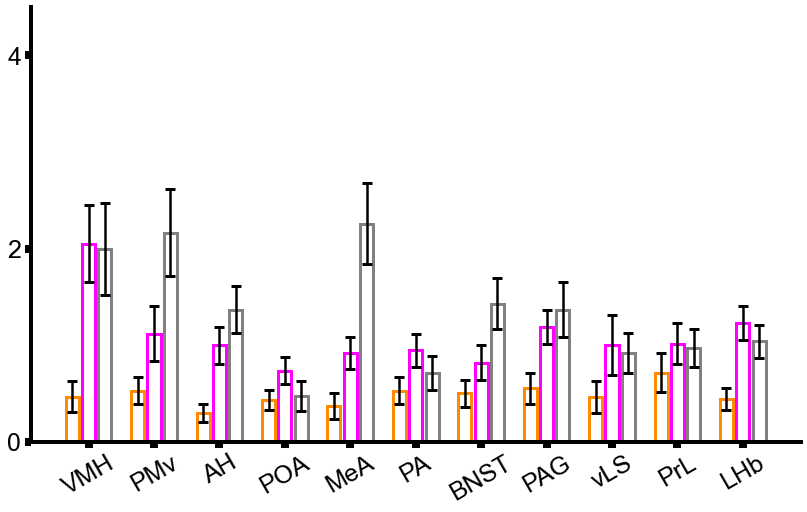

In [402]:
periods = [260, 340]
agg_prep = agg_peths_hf_notGrouped[periods[0]:periods[1]] - np.nanmedian(agg_peths_hf_notGrouped[100:160], axis=0)
obs_prep = obs_peths_hf_notGrouped[periods[0]:periods[1]] - np.nanmedian(obs_peths_hf_notGrouped[100:160], axis=0)
non_prep = non_peths_hf_notGrouped[periods[0]:periods[1]] - np.nanmedian(non_peths_hf_notGrouped[100:160], axis=0)

# computing difference between TP and HF

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

agg_diff = agg_prep.copy()
obs_diff = obs_prep.copy()
non_diff = non_prep.copy()
mean_func = np.nanmean
new_region_ids = [s.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for s in region_ids]
idxs2loop = np.array([12, 16, 10, 20, 0, 14, 8, 4, 6, 2, 18, 13, 17, 11, 21, 1, 15, 9, 5, 7, 3, 19, 22])
idxs2loop = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19])
amped_idxs = (np.arange(23)*4)[:11]
widths=3
plt.figure(figsize=(13.8, 8))
for r, (roi, roi_amp) in enumerate(zip(idxs2loop, amped_idxs)):
    print(region_ids[roi])
    run_atk_stats_ANOVA([mean_func(agg_diff[:, roi], axis=0), mean_func(obs_diff[:, roi], axis=0), mean_func(non_diff[:, roi], axis=0)])
    plt.bar(roi_amp, mean_func(agg_diff[:, roi]), color='white', edgecolor='darkorange', linewidth=widths)
    plt.bar(roi_amp+1, mean_func(obs_diff[:, roi]), color='white', edgecolor='magenta', linewidth=widths)
    plt.bar(roi_amp+2, mean_func(non_diff[:, roi]), color='white', edgecolor='gray', linewidth=widths)

    plt.errorbar(roi_amp, mean_func(agg_diff[:, roi]), yerr=np.nanstd(agg_diff[:, roi])/np.sqrt(agg_diff.shape[2]), color='black', 
    capsize=5, markeredgewidth=widths)
    plt.errorbar(roi_amp+1, mean_func(obs_diff[:, roi]), yerr=np.nanstd(obs_diff[:, roi])/np.sqrt(obs_diff.shape[2]), color='black', 
    capsize=5, markeredgewidth=widths)
    plt.errorbar(roi_amp+2, mean_func(non_diff[:, roi]), yerr=np.nanstd(non_diff[:, roi])/np.sqrt(non_diff.shape[2]), color='black', 
    capsize=5, markeredgewidth=widths)

plt.xticks(amped_idxs+1, [new_region_ids[i] for i in idxs2loop], rotation=30, fontfamily='Arial');
sns.despine()
plt.ylim(bottom=0, top=4.5)
plt.yticks([0, 2, 4], fontfamily='Arial')
# plt.savefig('./figures/HF_inhibitory_activity.svg', dpi=300)

VMH (E)
H = 2.092452, p = 0.351261
###
PMv (E)
H = 4.037867, p = 0.132797
###
AH (E)
H = 16.891264, p = 0.000215
AGG vs NON; U = 931.000000, p = 0.000192
AGG vs OBS; U = 2594.000000, p = 0.380390
OBS vs NON; U = 1321.000000, p = 0.008862
###
POA (E)
H = 4.488766, p = 0.105993
###
MeA (E)
H = 16.666859, p = 0.000240
AGG vs NON; U = 949.000000, p = 0.000291
AGG vs OBS; U = 2319.000000, p = 0.036790
OBS vs NON; U = 1496.000000, p = 0.101909
###
PA (E)
H = 1.443894, p = 0.485806
###
BNST (E)
H = 1.097674, p = 0.577621
###
PAG (E)
H = 4.249910, p = 0.119438
###
vLS (E)
H = 13.370737, p = 0.001249
AGG vs NON; U = 1111.000000, p = 0.007981
AGG vs OBS; U = 2114.000000, p = 0.003672
OBS vs NON; U = 1970.000000, p = 1.000000
###
PrL (E)
H = 5.652253, p = 0.059242
AGG vs NON; U = 1290.000000, p = 0.131153
AGG vs OBS; U = 2444.000000, p = 0.118166
OBS vs NON; U = 1957.000000, p = 1.000000
###
LHb (E)
H = 26.219010, p = 0.000002
AGG vs NON; U = 636.000000, p = 0.000004
AGG vs OBS; U = 1532.000000, 

([<matplotlib.axis.YTick at 0x15dd36ec0d0>,
 [Text(0, 0, '0'), Text(0, 2, '2'), Text(0, 4, '4')])

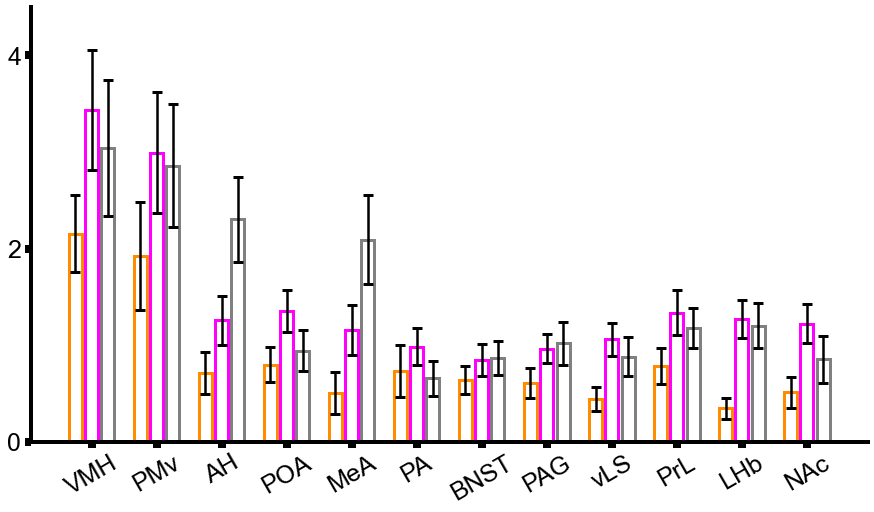

In [438]:
periods = [260, 340]
agg_prep = agg_peths_hf_notGrouped[periods[0]:periods[1]] - np.nanmedian(agg_peths_hf_notGrouped[100:160], axis=0)
obs_prep = obs_peths_hf_notGrouped[periods[0]:periods[1]] - np.nanmedian(obs_peths_hf_notGrouped[100:160], axis=0)
non_prep = non_peths_hf_notGrouped[periods[0]:periods[1]] - np.nanmedian(non_peths_hf_notGrouped[100:160], axis=0)

# computing difference between TP and HF

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

agg_diff = agg_prep.copy()
obs_diff = obs_prep.copy()
non_diff = non_prep.copy()
mean_func = np.nanmean
new_region_ids = [s.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for s in region_ids]
idxs2loop = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 23])-1
amped_idxs = (np.arange(23)*4)[:12]
widths=3
plt.figure(figsize=(15, 8))
for r, (roi, roi_amp) in enumerate(zip(idxs2loop, amped_idxs)):
    print(region_ids[roi])
    run_atk_stats_ANOVA([mean_func(agg_diff[:, roi], axis=0), mean_func(obs_diff[:, roi], axis=0), mean_func(non_diff[:, roi], axis=0)])
    plt.bar(roi_amp, mean_func(agg_diff[:, roi]), color='white', edgecolor='darkorange', linewidth=widths)
    plt.bar(roi_amp+1, mean_func(obs_diff[:, roi]), color='white', edgecolor='magenta', linewidth=widths)
    plt.bar(roi_amp+2, mean_func(non_diff[:, roi]), color='white', edgecolor='gray', linewidth=widths)

    plt.errorbar(roi_amp, mean_func(agg_diff[:, roi]), yerr=np.nanstd(agg_diff[:, roi])/np.sqrt(agg_diff.shape[2]), color='black', 
    capsize=5, markeredgewidth=widths)
    plt.errorbar(roi_amp+1, mean_func(obs_diff[:, roi]), yerr=np.nanstd(obs_diff[:, roi])/np.sqrt(obs_diff.shape[2]), color='black', 
    capsize=5, markeredgewidth=widths)
    plt.errorbar(roi_amp+2, mean_func(non_diff[:, roi]), yerr=np.nanstd(non_diff[:, roi])/np.sqrt(non_diff.shape[2]), color='black', 
    capsize=5, markeredgewidth=widths)

plt.xticks(amped_idxs+1, [new_region_ids[i] for i in idxs2loop], rotation=30, fontfamily='Arial');
sns.despine()
plt.ylim(bottom=0, top=4.5)
plt.yticks([0, 2, 4], fontfamily='Arial')
# plt.savefig('./figures/HF_excitatory_activity.svg', dpi=300)